
# Lab 2  CLASSIFICATION-- North Carolina Education Data Set

** Austin Hancock, Shravan Kuchkula, Kevin Okiah, Damarcus Thomas **

### Introduction.

North Carolina students continue to make gains on most measures of student learning, according to school accountability data released (News Release School-Year 2016-2017) to the State Board of Education, with more than 75 percent of public schools overall earning grades of C or better in the third year of the state’s A-F grading system.

School grades, required by state law, continue to correlate closely with the poverty levels of schools. Among all schools last year that received a D or F, 93 percent had enrollments with at least 50 percent of students from low-income families. Conversely, among schools that received at least a B, 75.7 percent had enrollments with less than 50 percent of students from low-income families.

In terms of growth achieved by schools this past year, 27.5 percent exceeded expected growth, virtually unchanged from 2014-15; 46.1 percent of schools met their expected performance, up from 44.7 percent in the previous year; and 26.4 percent fell short of their expected result, down from 27.7 percent the year before. The percentages of schools falling into the three growth categories have remained constant since 2012-13, with slight annual fluctuations up and down.

Full News Release Article http://www.ncpublicschools.org/newsroom/news/2016-17/20160901-01



###  Part 1: Data Preparation - Define and prepare class variables


>#### Data Source

>For this project we'll be using the North Carolina Schools education data set. The data we use is a combination of multiple data tables publicly available by the North Carolina Department of Public Instruction (NCDPI) which is charged with implementing the state's public-school laws and the State Board of Education's policies and procedures governing pre-kindergarten through 12th grade public education. You can learn more about the data by visiting http://www.ncpublicschools.org/data/reports/

>Our starting datasets [All_Data_By_School_Final] and [1516_Test_Scores] were taken from Dr. Drews GitHub https://github.com/jakemdrew/EducationDataNC where he combines multiple datasets from North Carolina Schools education data, preprocesses them and cleans them for Machine learning.

>We performed Visualization of high school’s data subset from this data, in our visualization lab hosted at https://github.com/kevimwe/NC_EDUCATION_DATA/tree/master/NC_EDUC_Visualization_Data_Processing.

>To gauge the health of the education system in the state of North Carolina, our team is going to focus on building models to classify the four-year graduation rate `Graduation_Rate4_Yr` on High school data. 
 
>Our team will build classification models to classify schools based on graduation rate of High Schools. We will begin by creating a categorical feature "Above_Avg_Graduation_Rate4_Yr" based `Graduation_Rate4_Yr`. "Above_Avg_Graduation_Rate4_Yr" is a binary feature binning schools as 1 if their Graduation_Rate4_Yr is above North Carolina (NC) four-year average High school graduation rate (85.4%) per http://www.dpi.state.nc.us/newsroom/news/2015-16/20150902-01 or 0 if the school’s Graduation_Rate4_Yr is below the NC State Average graduation rate. We will look at ROC curves, AUC, confusion matrix to see how well our classifiers fit our data perform.

>For both cases our team hopes to measure the accuracy and performance of our models by leveraging Stratified 10-Fold Cross Validation which will be discussed in detail in our results section of this report.

#### Loading the data

>In the code block below, we import python modules that we will use in our analysis and load [All_Data_By_School_Final] and [1516_Test_Scores] from Dr. Drews GitHub https://github.com/jakemdrew/EducationDataNC. All_Data_By_School_Final has 2579 rows, 293 features. Dr. Drew consolidated All_Data_By_School_Final from various tables within the NC Statistical Profiles and Report Card Databases. Each row represents a public school in the state of North Carolina and each feature is a school's attainment level. 1516_Test_Scores on the other end is school level attainment data containing 2669 rows, 73 features. The rows represent a school and the features are Percentage of entire student body meeting various subject, End of Grade (EOG), End of Course (EOC), ACT and Graduation Rate benchmarks.

>All_Data_By_School_Final and 1516_Test_Scores get merged on 'unit_code': a unique identifier for the schools in the state of North Carolina to form 'SchoolData' which we will proceed with for further preprocessing.


In [64]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#import required Libraries
import pandas as pd
import numpy as np

import os 
pd.set_option('display.max_colwidth', -1)
import requests
import io

# Import the stats library
from scipy import stats
import statsmodels.api as sm

# These are the plotting libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use("classic")
import seaborn as sns

#Machine learning
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

# Command for plots to appear in the iPython Notebook
%matplotlib inline
wd = os.getcwd() #get working directory

#Read in raw data

#Get school level data
url="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/Raw%20Datasets/All_Data_By_School_Final.csv"
schoolData=pd.read_csv(url, low_memory=False)

#Get test scores level data 
url="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/Raw%20Datasets/1516_Test_Scores.csv"
testScores=pd.read_csv(url, low_memory=False)

#Review raw data before the join
schoolData.info()

#join files using school / unit code
# schoolData = schoolData.join(testScores, on='unit_code',how='left', lsuffix='_schoolData', rsuffix='_testScores')
schoolData = schoolData.merge(testScores, on='unit_code', how='left', suffixes=('_schoolData', '_testScores'))
schoolData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 293 entries, Year to State_Prin_Exp_Pct_10+_Years
dtypes: float64(255), int64(17), object(21)
memory usage: 5.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 365 entries, Year to Passing_Math_III
dtypes: float64(324), int64(17), object(24)
memory usage: 7.2+ MB


In [65]:
schoolData.shape

(2579, 365)

In [66]:
#Remove fields not needed for machine learning
# Code block below is taken from Dr. Drew's notebook on graduation rate from his github link above.
excludeFields = ['Year','unit_code_schoolData', 'street_ad','scity_ad','state_ad','szip_ad','Closed_Ind_Text','New_ind_Txt',
                 'grades_BYOD','grades_1_to_1_access','District Name','unit_code_testScores','School Name','SBE District']

keepFields = [col for col in schoolData.columns if col not in excludeFields]

schoolData = schoolData[keepFields]

schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: float64(324), int64(15), object(14)
memory usage: 7.0+ MB


In [67]:
schoolData.shape

(2579, 353)

> In the code block above we drop 12 features from our dataset from the get go. These are features that are unique for each of the records i.e. Street_ad, State_ad, School name etc. Since these features are unique to each record, they won't add value to our machine learning models.

In [68]:
#Clean up the dataset for machine learning 
boolFields = ['title1_type_flg', 'clp_ind_flg', 'focus_clp_flg', 'summer_program_flg', 
              'asm_no_spg_flg', 'no_data_spg_flg', 'stem_flg']

# Map flag fields into bool 
schoolData['title1_type_flg'] = schoolData['title1_type_flg'].map({-1:True, 0:False})
schoolData['clp_ind_flg'] = schoolData['clp_ind_flg'].map({-1:True, 0:False})
schoolData['focus_clp_flg'] = schoolData['focus_clp_flg'].map({-1:True, 0:False})
schoolData['summer_program_flg'] = schoolData['summer_program_flg'].map({-1:True, 0:False})
schoolData['asm_no_spg_flg'] = schoolData['asm_no_spg_flg'].map({-1:True, 0:False})
schoolData['no_data_spg_flg'] = schoolData['no_data_spg_flg'].map({-1:True, 0:False})
schoolData['stem_flg'] = schoolData['stem_flg'].map({-1:True, 0:False})

#
schoolData['esea_status'] = schoolData['esea_status'].map({'P':'Esea_Pass', 'F':'Esea_Fail', np.nan:'Non_Esea'})
schoolData['Grad_project_status'] = schoolData['Grad_project_status'].map({'Y':True, 'N':False, np.nan:False})

> In the code block above taken from Dr.Drews notebook, boolean fields are mapped into 1s and 0s for machine learning

In [69]:
highSchools = schoolData [((schoolData.category_cd == 'H') | 
                          (schoolData.category_cd == 'T') | 
                          (schoolData.category_cd == 'A'))&
                          (schoolData.Graduation_Rate4_Yr > 0) &
                          (schoolData.student_num > 0) & 
                          (schoolData.type_cd_txt == 'Public') & 
                          (schoolData.school_type_txt == 'Regular School')
                         ]

highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: bool(8), float64(324), int64(8), object(13)
memory usage: 1.2+ MB


In [70]:
highSchools.shape

(440, 353)

> Since our team targets to classify and build models to predict High schools’ four-year graduation rate, the data was filtered to only schools’ categories that have high school grades based on category_cd flag. Our resulting dataset has 440 records.

> In the code block below taken from Dr. Drew's notebook, 225 columns are dropped from our high school data based on several reasons ranging from; feature not being applicable to High Schools, features having the same value for all the records, to duplicated fields or having 100% NANs. Please refer to comments as to why a column was dropped.


In [71]:
#High school - excluded fields and reasons
excludeFeaturesHS = ['no_data_spg_flg', #all false or NaN
 'Avg_Class_Size_00', #NA for High Schools
 'Avg_Class_Size_01', #NA for High Schools
 'Avg_Class_Size_02', #NA for High Schools
 'Avg_Class_Size_03', #NA for High Schools
 'Avg_Class_Size_04', #NA for High Schools
 'Avg_Class_Size_05', #NA for High Schools
 'Avg_Class_Size_06', #NA for High Schools
 'Avg_Class_Size_07', #NA for High Schools
 'Avg_Class_Size_08', #NA for High Schools
 'Avg_Dist_Size_00', #NA for High Schools
 'Avg_Dist_Size_01', #NA for High Schools
 'Avg_Dist_Size_02', #NA for High Schools
 'Avg_Dist_Size_03', #NA for High Schools
 'Avg_Dist_Size_04', #NA for High Schools
 'Avg_Dist_Size_05', #NA for High Schools
 'Avg_Dist_Size_06', #NA for High Schools
 'Avg_Dist_Size_07', #NA for High Schools
 'Avg_Dist_Size_08', #NA for High Schools
 'Avg_State_Size_00', #NA for High Schools
 'Avg_State_Size_01', #NA for High Schools
 'Avg_State_Size_02', #NA for High Schools
 'Avg_State_Size_03', #NA for High Schools
 'Avg_State_Size_04', #NA for High Schools
 'Avg_State_Size_05', #NA for High Schools
 'Avg_State_Size_06', #NA for High Schools
 'Avg_State_Size_07', #NA for High Schools
 'Avg_State_Size_08', #NA for High Schools
 'total_expense_num', #494 NaN
 'salary_expense_pct', #494 NaN
 'services_expense_pct', #494 NaN
 'supplies_expense_pct', #494 NaN
 'instruct_equip_exp_pct', #494 NaN
 'other_expense_pct', #494 NaN
 'federal_perpupil_num', #494 NaN
 'local_perpupil_num', #494 NaN
 'state_perpupil_num', #494 NaN
 'lea_other_expense_pct', #All 0 or NaN
 'st_total_expense_num', #Same Value
 'st_salary_expense_pct', #Same Value
 'st_benefits_expense_pct', #Same Value
 'st_services_expense_pct', #Same Value
 'st_supplies_expense_pct', #Same Value
 'st_instruct_equip_exp_pct', #Same Value
 'st_other_expense_pct', #Same Value
 'st_federal_perpupil_num', #Same Value
 'st_local_perpupil_num', #Same Value
 'st_state_perpupil_num', #Same Value
 'Reading SPG Grade', #NA for High Schools
 'Reading  SPG Score', #NA for High Schools
 'Math SPG Grade', #NA for High Schools
 'Math SPG Score', #NA for High Schools
 'Read Score', #NA for High Schools
 'Math Score', #NA for High Schools
 'Science Score', #NA for High Schools
 'ACT WorkKeys Score', #81 NaN
 'GCE_LEP_School_Pct', #440 NaN
 'GCE_PRM_School_Pct', #440 NaN
 'GCE_RPF_School_Pct', #440 NaN
 'GCE_SWD_School_Pct', #440 NaN
 'PASSED_EOG_School_Pct', #438 NaN
 'PASSED_LAA_School_Pct', #440 NaN
 'PASSED_RTA_School_Pct', #440 NaN
 'PROMOTED_School_Pct', #438 NaN
 'RETAINED_School_Pct', #440 NaN
 'GCE_ALL_Dist_Pct', #437 NaN
 'GCE_LEP_Dist_Pct', #440 NaN
 'GCE_PRM_Dist_Pct', #440 NaN
 'GCE_RPF_Dist_Pct', #439 NaN
 'GCE_SWD_Dist_Pct', #438 NaN
 'PASSED_EOG_Dist_Pct', #437 NaN
 'PASSED_LAA_Dist_Pct', #438 NaN
 'PASSED_RTA_Dist_Pct', #440 NaN
 'PROMOTED_Dist_Pct', #437 NaN
 'RETAINED_Dist_Pct', #438 NaN
 'GCE_ALL_State_Pct', #437 NaN
 'GCE_LEP_State_Pct', #440 NaN
 'GCE_PRM_State_Pct', #440 NaN
 'GCE_RPF_State_Pct', #440 NaN
 'GCE_SWD_State_Pct', #437 NaN
 'PASSED_EOG_State_Pct', #437 NaN
 'PASSED_LAA_State_Pct', #437 NaN
 'PASSED_RTA_State_Pct', #440 NaN
 'PROMOTED_State_Pct', #437 NaN
 'RETAINED_State_Pct', #437 NaN
 'st_sat_avg_score_num  ', #All Same Value 
 'nat_sat_avg_score_num', #All Same Value
 'st_sat_participation_pct', #All Same Value 
 'nat_sat_participation_pct', #All Same Value
 'esea_attendance', #440 NaN
 'lea_esea_attendance', #440 NaN
 'st_ap_participation_pct', #All Same Value
 'st_ap_pct_3_or_above', #All Same Value
 'ib_participation_pct', #434 NaN
 'lea_ib_participation_pct', #440 NaN
 'st_ib_participation_pct', #440 NaN
 'ib_pct_4_or_above', #416 NaN
 'lea_ib_pct_4_or_above', #261 NaN
 'st_ib_pct_4_or_above', #All Same Value
 'st_total_specialized_courses', #All Same Value
 'st_ap_ib_courses ', #All Same Value
 'st_cte_courses', #All Same Value
 'st_univ_college_courses', #All Same Value
 'ttl_crimes_num', #440 NaN
 'st_expelled_per_c_num', #All Same Value
 'st_avg_age_media_collection ', #All Same Value
 'st_books_per_student', #All Same Value
 'st_wap_num', #All Same Value
 'st_wap_per_classroom', #All Same Value
 'prin_other_pct', #440 NaN
 'prinyrs_0thru3_pct', #440 NaN
 'prinyrs_4thru10_pct', #440 NaN
 'prinyrs_11plus_pct', #440 NaN
 'prin_advance_dgr_pct', #440 NaN
 '_1yr_prin_trnovr_pct', #440 NaN
 'prin_male_pct', #440 NaN
 'prin_female_pct', #440 NaN
 'prin_black_pct', #440 NaN
 'prin_white_pct', #440 NaN
 'emer_prov_teach_pct    ', #385 NaN 
 'st_highqual_class_hp_pct ', #All Same Value
 'st_highqual_class_lp_pct ', #All Same Value
 'st_highqual_class_all_pct ', #All Same Value
 'st_not_highqual_class_hp_pct ', #All Same Value
 'st_not_highqual_class_lp_pct ', #All Same Value
 'st_not_highqual_class_all_pct ', #All Same Value
 'st_prinyrs_0thru3_pct ', #All Same Value
 'st_prinyrs_4thru10_pct ', #All Same Value
 'st_prinyrs_11plus_pct', #All Same Value
 'st_prin_advance_dgr_pct', #All Same Value
 'st_1yr_prin_trnovr_pct ', #All Same Value
 'st_prin_male_pct ', #All Same Value
 'st_prin_female_pct ', #All Same Value
 'st_prin_black_pct ', #All Same Value
 'st_prin_white_pct', #All Same Value
 'st_prin_other_pct', #All Same Value
 'State_Prin_Exp_Pct_0_3_Years ', #All Same Value
 'State_Prin_Exp_Pct_4_10_Years ', #All Same Value
 'State_Prin_Exp_Pct_10+_Years ', #All Same Value
 'All_EOG_Subjects_CACR', #428 NaN 
 'All_EOG_Subjects_GLP', #428 NaN 
 'EOG_Gr3_CACR', #NA for High Schools
 'EOG_Gr3_GLP', #NA for High Schools
 'EOG_Gr4_CACR', #NA for High Schools
 'EOG_Gr4_GLP', #NA for High Schools
 'EOG_Gr5_CACR', #NA for High Schools
 'EOG_Gr5_GLP', #NA for High Schools
 'EOG_Gr6_CACR', #NA for High Schools
 'EOG_Gr6_GLP', #NA for High Schools
 'EOG_Gr7_CACR', #NA for High Schools
 'EOG_Gr7_GLP', #NA for High Schools
 'EOG_Gr8_CACR', #NA for High Schools
 'EOG_Gr8_GLP', #NA for High Schools
 'EOG_Math_Gr3_CACR', #NA for High Schools
 'EOG_Math_Gr3_GLP', #NA for High Schools
 'EOG_Math_Gr3-8_CACR', #NA for High Schools
 'EOG_Math_Gr3-8_GLP', #NA for High Schools
 'EOG_Math_Gr4_CACR', #NA for High Schools
 'EOG_Math_Gr4_GLP', #NA for High Schools
 'EOG_Math_Gr5_CACR', #NA for High Schools
 'EOG_Math_Gr5_GLP', #NA for High Schools
 'EOG_Math_Gr6_CACR', #NA for High Schools
 'EOG_Math_Gr6_GLP', #NA for High Schools
 'EOG_Math_Gr7_CACR', #NA for High Schools
 'EOG_Math_Gr7_GLP', #NA for High Schools
 'EOG_Math_Gr8_CACR', #NA for High Schools
 'EOG_Math_Gr8_GLP', #NA for High Schools
 'EOG_Reading_G3_GLP', #NA for High Schools
 'EOG_Reading_Gr3_CACR', #NA for High Schools
 'EOG_Reading_Gr4_CACR', #NA for High Schools
 'EOG_Reading_Gr4_GLP', #NA for High Schools
 'EOG_Reading_Gr5_CACR', #NA for High Schools
 'EOG_Reading_Gr5_GLP', #NA for High Schools
 'EOG_Reading_Gr6_CACR', #NA for High Schools
 'EOG_Reading_Gr6_GLP', #NA for High Schools
 'EOG_Reading_Gr7_CACR', #NA for High Schools
 'EOG_Reading_Gr7_GLP', #NA for High Schools
 'EOG_Reading_Gr8_CACR', #NA for High Schools
 'EOG_Reading_Gr8_GLP', #NA for High Schools
 'EOG_Reading_Grades_3_8_CACR', #NA for High Schools
 'EOG_Reading_Grades_3_8_GLP', #NA for High Schools
 'EOG_Science_Gr5_CACR', #NA for High Schools
 'EOG_Science_Gr5_GLP', #NA for High Schools
 'EOG_Science_Gr8_CACR', #NA for High Schools
 'EOG_Science_Gr8_GLP', #NA for High Schools
 'EOG_Science_Grades_5&8_CACR', #NA for High Schools
 'EOG_Science_Grades_5&8_GLP', #NA for High Schools
 'Graduation_Rate_5_Yr', #Using 4 year graduation rate as response variable
 'type_cd_txt', #Only 'Public' after filter
 'school_type_txt', #Only 'Regular School' after filter 
 'asm_no_spg_flg', #All False after filters
 'benefits_expense_pct', #440 NaN
 'State Gap Compared', #360 NaN
 'GCE_ALL_School_Pct', #437
 'emer_prov_teach_pct', #385 NaN
 'lea_emer_prov_teach_pct', #226 NaN 
 'Avg_State_Size_Biology', #All same value
 'Avg_State_Size_EnglishII', #All same value
 'Avg_State_Size_MathI', #All same value
 'st_sat_avg_score_num', #All same value 
 'st_ap_ib_courses', #All same value
 'st_avg_daily_attend_pct', #All same value
 'st_crime_per_c_num', #All same value
 'st_short_susp_per_c_num', #All same value
 'st_long_susp_per_c_num', #All same value
 'st_stud_internet_comp_num', #All same value
 'st_avg_age_media_collection', #All same value
 'st_flicensed_teach_pct', #All same value
 #'st_tchyrs_0thru3_pct', #All same value
 #'st_tchyrs_4thru10_pct', #All same value
 #'st_tchyrs_11plus_pct', #All same value
 'st_class_teach_num', #All same value
 'st_nbpts_num', #All same value
 'st_advance_dgr_pct', #All same value
 'st_1yr_tchr_trnovr_pct', #All same value
 'st_emer_prov_teach_pct', #All same value
 'st_lateral_teach_pct', #All same value
 'st_highqual_class_pct', #All same value
 'st_highqual_class_hp_pct', #All same value
 'st_highqual_class_lp_pct', #All same value
 'st_highqual_class_all_pct', #All same value
 'st_not_highqual_class_hp_pct', #All same value
 'st_not_highqual_class_lp_pct', #All same value
 'st_not_highqual_class_all_pct', #All same value
 'st_prinyrs_0thru3_pct', #All same value
 'st_prinyrs_4thru10_pct', #All same value
 'st_1yr_prin_trnovr_pct', #All same value
 'st_prin_male_pct', #All same value
 'st_prin_female_pct', #All same value
 'st_prin_black_pct', #All same value
 'State_Tch_Exp_Pct_0_3_Years', #All same value
 'State_Tch_Exp_Pct_4_10_Years', #All same value
 'State_Tch_Exp_Pct_10+_Years', #All same value
 'State_Prin_Exp_Pct_0_3_Years', #All same value
 'State_Prin_Exp_Pct_4_10_Years', #All same value
 'State_Prin_Exp_Pct_10+_Years', #All same value
 'st_avg_student_num', #All same value 
 'unit_code', #School primary key, different for all records
 #-----------------------Added 01/30/2018------------------------
 #Removes dup fields to avoid Multicollinearity
 'tchyrs_0thru3_pct', #Duplicate field -> Tch_Exp_Pct_0_3_Years
 'tchyrs_4thru10_pct', #Duplicate field -> Tch_Exp_Pct_4_10_Years
 'tchyrs_11plus_pct', #Duplicate field -> Tch_Exp_Pct_10+_Years
 'lea_tchyrs_0thru3_pct', #Duplicate field -> Dist_Tch_Exp_Pct_0_3_Years
 'lea_tchyrs_4thru10_pct', #Duplicate field -> Dist_Tch_Exp_Pct_4_10_Years
 'lea_tchyrs_11plus_pct', #Duplicate field -> Dist_Tch_Exp_Pct_10+_Years
 'st_tchyrs_0thru3_pct', #Duplicate field -> State_Tch_Exp_Pct_0_3_Years
 'st_tchyrs_4thru10_pct', #Duplicate field -> State_Tch_Exp_Pct_4_10_Years
 'st_tchyrs_11plus_pct', #Duplicate field -> State_Tch_Exp_Pct_10+_Years
                    ]

keepFields = [col for col in highSchools.columns if col not in excludeFeaturesHS]

highSchools = highSchools[keepFields]

highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Columns: 128 entries, category_cd to Passing_Math_III
dtypes: bool(6), float64(115), object(7)
memory usage: 425.4+ KB


In [72]:
highSchools.shape

(440, 128)

#### Missing Data

In [73]:
#Review Missing values 
missing_values = highSchools.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 

#Print all rows with missing values
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(missing_values)

                                      Variable Name  Number Missing Values
11   Avg_Class_Size_Biology                          9                    
12   Avg_Class_Size_EnglishII                        8                    
13   Avg_Class_Size_MathI                            12                   
14   Avg_Dist_Size_Biology                           7                    
15   Avg_Dist_Size_EnglishII                         7                    
16   Avg_Dist_Size_MathI                             7                    
26   SPG Grade                                       1                    
27   SPG Score                                       1                    
28   EVAAS Growth Status                             8                    
29   EVAAS Growth Score                              8                    
30   Overall Achievement Score                       1                    
31   Math I Score                                    9                    
32   English II Score    

In [74]:
#Check for missing values
HighSchoolS = highSchools.copy()
Temp = pd.DataFrame(HighSchoolS.isnull().sum())
#print(Temp)
Temp.columns =['DataMissing']
#Columns with at least 1 missing value
MissingCount = Temp[Temp.DataMissing>0]

#sort 
MissingCount = MissingCount.sort_values('DataMissing',ascending=False)
#basic stats on missing data
print("##################################################")
print("###", '             Stats on missing data        ',  "###")
print("##################################################")
print('No. of rows in HighSchoolS: ',len(HighSchoolS))
print('No. of Columns in HighSchoolS: ',len(HighSchoolS.columns))
print('No. of Columns with Missing data: ',len(MissingCount))
print('No. of Complete data columns: ', len(HighSchoolS.columns) - len(MissingCount))
print('No. of Columns with 100% missing Values: ',sum(1 for item in MissingCount.DataMissing if item==len(HighSchoolS)))
print('% of Columns with some Missing data: ',round(float(100*len(MissingCount))/len(HighSchoolS.columns),3),'%')
print('% of Columns with 100% Missing data: ',round(float(100*sum(1 for item in MissingCount.DataMissing if item==len(HighSchoolS)))/len(HighSchoolS.columns),3),'%')

print(" ")
print("##################################################")
print("###",'       Columns with  missing data     ',    "###")
print("##################################################")
#add a columnName for Bar charts plot
MissingCount['ColumnName'] = MissingCount.index
MissingCount['Missing %'] = 100*(MissingCount.DataMissing/len(HighSchoolS))
MissingCount = MissingCount.reset_index()
del MissingCount['index']
print((MissingCount.head(100)))

##################################################
###              Stats on missing data         ###
##################################################
No. of rows in HighSchoolS:  440
No. of Columns in HighSchoolS:  128
No. of Columns with Missing data:  72
No. of Complete data columns:  56
No. of Columns with 100% missing Values:  0
% of Columns with some Missing data:  56.25 %
% of Columns with 100% Missing data:  0.0 %
 
##################################################
###        Columns with  missing data      ###
##################################################
    DataMissing                                      ColumnName  Missing %
0   132          ap_participation_pct                            30.000000
1   103          AP_Courses_Offered                              23.409091
2   94           ap_pct_3_or_above                               21.363636
3   85           ACT_WorkKeys_Silver_Beyond                      19.318182
4   79           1_to_1_access                

>From above we note, of the 128 columns in High School dataset, 72 features (56.25%) of them have some missing data while 56 features (43.625) have complete data.

>Our team chose to replace missing categorical values with mode and missing continuous values with median. in the code block that follows a total of 72 columns with missing values have been cleaned.


In [75]:
#this function replaces NA's for columns with continous 'Con' (int or float) variables with median and categorical 'Cat' variable(bool or object) with mode
def ReplaceMissingdata(df):
    temp_df = df.copy() 
    print("#######################################")
    print("## continous and categorical columns ##")
    print("#######################################")
    temp  = df.select_dtypes(include=['int64','float'])    #continuous values columns
    columnnames = temp.columns
    temp1  = df.select_dtypes(include=['object','bool']) #categorical values columns
    columnnames1 = temp1.columns
    print(" ")
    
    print("##############################")
    print("## NA count Before Cleaning ##")
    print("##############################")
    print(df.isnull().sum())
    #replacing missing continous values with median
    for i in range(0,len(columnnames)):
        try:
            temp_array =temp[temp[columnnames[i]]!=np.nan][columnnames[i]] #temp array of non NAs for continous values to calculate median
            # replace NAs with median for continous variables created from above arrays
            temp_df[columnnames[i]] =temp_df[columnnames[i]].replace(np.nan,temp_array.median())     
        except Exception as e:
            print(e.args) 
            
    #replacing missing contegorical values with mode
    for i in range(0,len(columnnames1)):
        try:
            temp_array1 =temp1[temp1[columnnames1[i]]!=np.nan][columnnames1[i]] #temp array of non NAs for categorical values to calculate mode
            # replace NAs with median for categorical values created from above arrays with mode
            temp_df[columnnames1[i]] =temp_df[columnnames1[i]].replace(np.nan,str(temp_array1.mode()[0]))      
        except Exception as e:
            print(e.args)

    print("##############################")
    print("## NA Count After Cleaning  ##")
    print("##############################")
    print(temp_df.isnull().sum())
    df = temp_df
    return df

HighSchools_Clean = ReplaceMissingdata(highSchools)    

HighSchools_Clean.info()

#######################################
## continous and categorical columns ##
#######################################
 
##############################
## NA count Before Cleaning ##
##############################
category_cd                       0 
calendar_only_txt                 0 
title1_type_flg                   0 
clp_ind_flg                       0 
focus_clp_flg                     0 
summer_program_flg                0 
esea_status                       0 
student_num                       0 
lea_avg_student_num               0 
Grad_project_status               0 
stem_flg                          0 
Avg_Class_Size_Biology            9 
Avg_Class_Size_EnglishII          8 
Avg_Class_Size_MathI              12
Avg_Dist_Size_Biology             7 
Avg_Dist_Size_EnglishII           7 
Avg_Dist_Size_MathI               7 
lea_total_expense_num             0 
lea_salary_expense_pct            0 
lea_benefits_expense_pct          0 
lea_services_expense_pct          0 
lea_supp

In [76]:
HighSchools_Clean.shape

(440, 128)

#### Final Dataset and New Features

In [77]:

#################################################
#               New Features                    #
#################################################
#1
# create Factors for 'Overall Achievement Score'
# A: 85-100
# B: 70-84
# C: 55-69
# D: 40-54
# F:<40
new_schooldata =HighSchools_Clean.copy()
new_schooldata = new_schooldata.assign(Overall_Achievement_Score_bins = pd.cut(np.array(new_schooldata['Overall Achievement Score']), 
                                              5, labels=["<40", "40-54", "55-69",'70-84',"85-100"]))
#2 
#SchoolWeightedScore:  Summation of all achievement measures Scores.
bin1 = ['EVAAS Growth Score','Overall Achievement Score' , 'SPG Score', 'Cohort Graduation Rate Standard Score'] # school perfomance Weight 0.6
bin2 = ['The ACT Score' ,'Math Course Rigor Score', 'sat_avg_score_num'] # College Prep weight 0.3
bin3 = ['Math I Score', 'English II Score','Biology Score'] # EOC scores weight 0.1
#print(Achievement_measures)
new_schooldata = new_schooldata.assign(BIN1=new_schooldata[bin1].sum(axis=1)*.6)
new_schooldata = new_schooldata.assign(BIN2=new_schooldata[bin2].sum(axis=1)*.3)
new_schooldata = new_schooldata.assign(BIN3=new_schooldata[bin3].sum(axis=1)*.1)
groupedbins = ['BIN1','BIN2','BIN3']
new_schooldata = new_schooldata.assign(SchoolWeightedScore = new_schooldata[groupedbins].sum(axis =1))

#3 Binned Graduation_Rate4_Yr for classification. We create a new feature binary feature 'Above_NC_Graduation_Rate4_Yr'. 
# The feature will be 1 if the school has a Graduation_Rate4_Yr => 85.4% which is the NC average highschool graduation rate else 0.
new_schooldata = new_schooldata.assign(Above_NC_AVG_Graduation_Rate4_Yr = np.where(new_schooldata['Graduation_Rate4_Yr']>=85.4, 1, 0))


School_Final = new_schooldata.drop(groupedbins, 1)
#School_Final.head().T


> From above code, we have created three new features.

> #### 1 .  Overall_Achievement_Score_bins: 
> This feature is used to group the Overall Achievement Scores into 5 different bins. The bins are selected based on  the splits from http://www.ncpublicschools.org/docs/accountability/reporting/spgbckgrndpack15.pdf

>> A: 85-100,

>> B: 70-84,

>> C: 55-69,

>> D: 40-54,

>> F:<40

> #### 2. SchoolWeightedScore:
> Summation of all achievement measures Scores.'EVAAS Growth Score','Overall Achievement Score’, 'SPG Score', 'Cohort Graduation Rate Standard Score' are put on bin1 and given a weight 0.6 of the overall weighted school as they describe the overall rating of a school. 'The ACT Score’, 'sat_avg_score_num', and `Math Course Rigor Score` are put in bin 2 carrying a weight of 0.3 while bin3 contains End of Course scores for `Math I Score`, `English II Score`, and `Biology Score` given a weight 0.1.

> #### 3. Above_NC_AVG_Graduation_Rate4_Yr:
> This is categorical feature created from Graduation_Rate4_Yr in comparison to North Carolinas state average 4-year high school graduation rate. If a school's Graduation_Rate4_Yr is above 85.4% (NC State Average High School graduation rate), the school is binned as 1 else 0. We will use this feature for the classification tasks. 

Below we visualize these three newly created features.


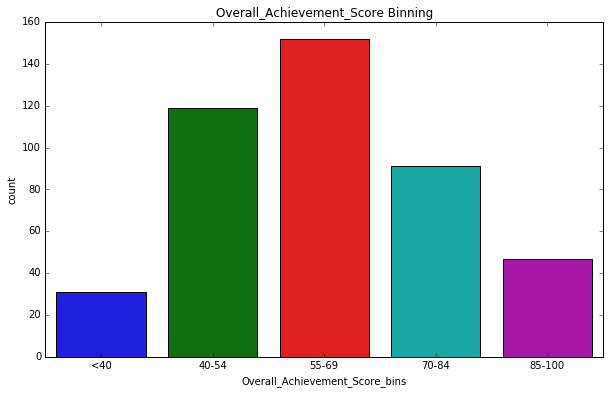

In [78]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="Overall_Achievement_Score_bins", data=new_schooldata )
plt.title('Overall_Achievement_Score Binning')

> majority of the schools have average overrall achievement score bin 56-69. For classification we will create dummy variable for each of this 5 bins.

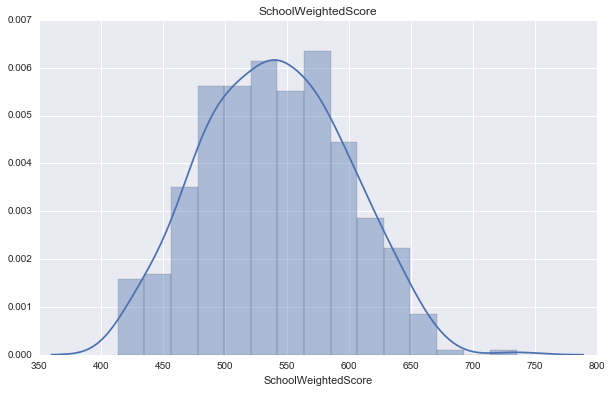

In [79]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(10, 6))
sns.distplot(new_schooldata.SchoolWeightedScore);
plt.title('SchoolWeightedScore')

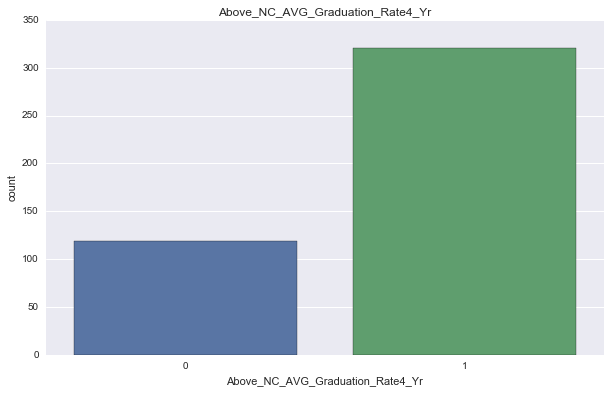

In [80]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="Above_NC_AVG_Graduation_Rate4_Yr", data=new_schooldata )
plt.title('Above_NC_AVG_Graduation_Rate4_Yr')

In [81]:
modelingdata=School_Final.copy()
modelingdata.head()

,category_cd,calendar_only_txt,title1_type_flg,clp_ind_flg,focus_clp_flg,summer_program_flg,esea_status,student_num,lea_avg_student_num,Grad_project_status,...,EOC_Biology_GLP,EOC_English_2_CACR,EOC_English_2_GLP,EOC_Math_I_CACR,EOC_Math_I_GLP,Graduation_Rate4_Yr,Passing_Math_III,Overall_Achievement_Score_bins,SchoolWeightedScore,Above_NC_AVG_Graduation_Rate4_Yr
116,H,Traditional Calendar,False,False,False,False,Non_Esea,311.0,947.0,True,...,90.4,93.8,100.0,80.3,90.8,100.0,100.0,85-100,639.16,1
122,H,Traditional Calendar,False,False,False,False,Non_Esea,1033.0,947.0,True,...,59.4,38.3,48.7,29.0,43.9,79.4,100.0,40-54,502.66,0
124,H,Traditional Calendar,False,False,False,False,Non_Esea,1096.0,947.0,True,...,58.8,50.5,61.4,41.9,55.1,84.0,100.0,55-69,566.24,0
132,H,Traditional Calendar,False,False,False,False,Non_Esea,1346.0,947.0,True,...,66.9,50.8,58.5,44.1,59.8,88.2,100.0,55-69,546.14,1
134,H,Traditional Calendar,False,False,False,False,Non_Esea,1279.0,779.0,True,...,62.3,63.7,69.4,46.4,61.2,92.8,100.0,70-84,583.86,1


>The code block below is derived from taken from Dr. Drews notebook on. We create dummy variables then use correlation to eliminate features with more than 0.95 correlation.

In [82]:
%%time
def dummy_Create(df):
    schoolDataFinal = df.copy()
    SchoolDataCat = schoolDataFinal.loc[:,(schoolDataFinal.dtypes == object) |(schoolDataFinal.dtypes == 'category')|(schoolDataFinal.dtypes == bool)]
    
    
    print(SchoolDataCat.columns)
    cat_vars=SchoolDataCat.columns
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(schoolDataFinal[var], prefix=var)
        df=pd.concat([df,cat_list], axis=1)
    data=df
    cat_vars=SchoolDataCat.columns
    data_vars=data.columns.values.tolist()
    
    to_keep=[i for i in data_vars if i not in cat_vars]

    ## Final data columns
    data_final=data[to_keep]
    data_final.columns.values
    data_final_vars=data_final.columns.values.tolist()
    #return(SchoolDataCat)
    y=['Above_NC_AVG_Graduation_Rate4_Yr']
    X=[i for i in data_final_vars if i not in y]
 
    list(data_final_vars)
    print(y)
    #print(X)
    SchoolDataCat.describe().T
    return(data_final.abs())
    
modelingdata = dummy_Create(modelingdata)


Index(['category_cd', 'calendar_only_txt', 'title1_type_flg', 'clp_ind_flg',
       'focus_clp_flg', 'summer_program_flg', 'esea_status',
       'Grad_project_status', 'stem_flg', 'SPG Grade', 'EVAAS Growth Status',
       'Byod', '1_to_1_access', 'Overall_Achievement_Score_bins'],
      dtype='object')
['Above_NC_AVG_Graduation_Rate4_Yr']
Wall time: 112 ms


(440, 154)
Wall time: 1.07 s


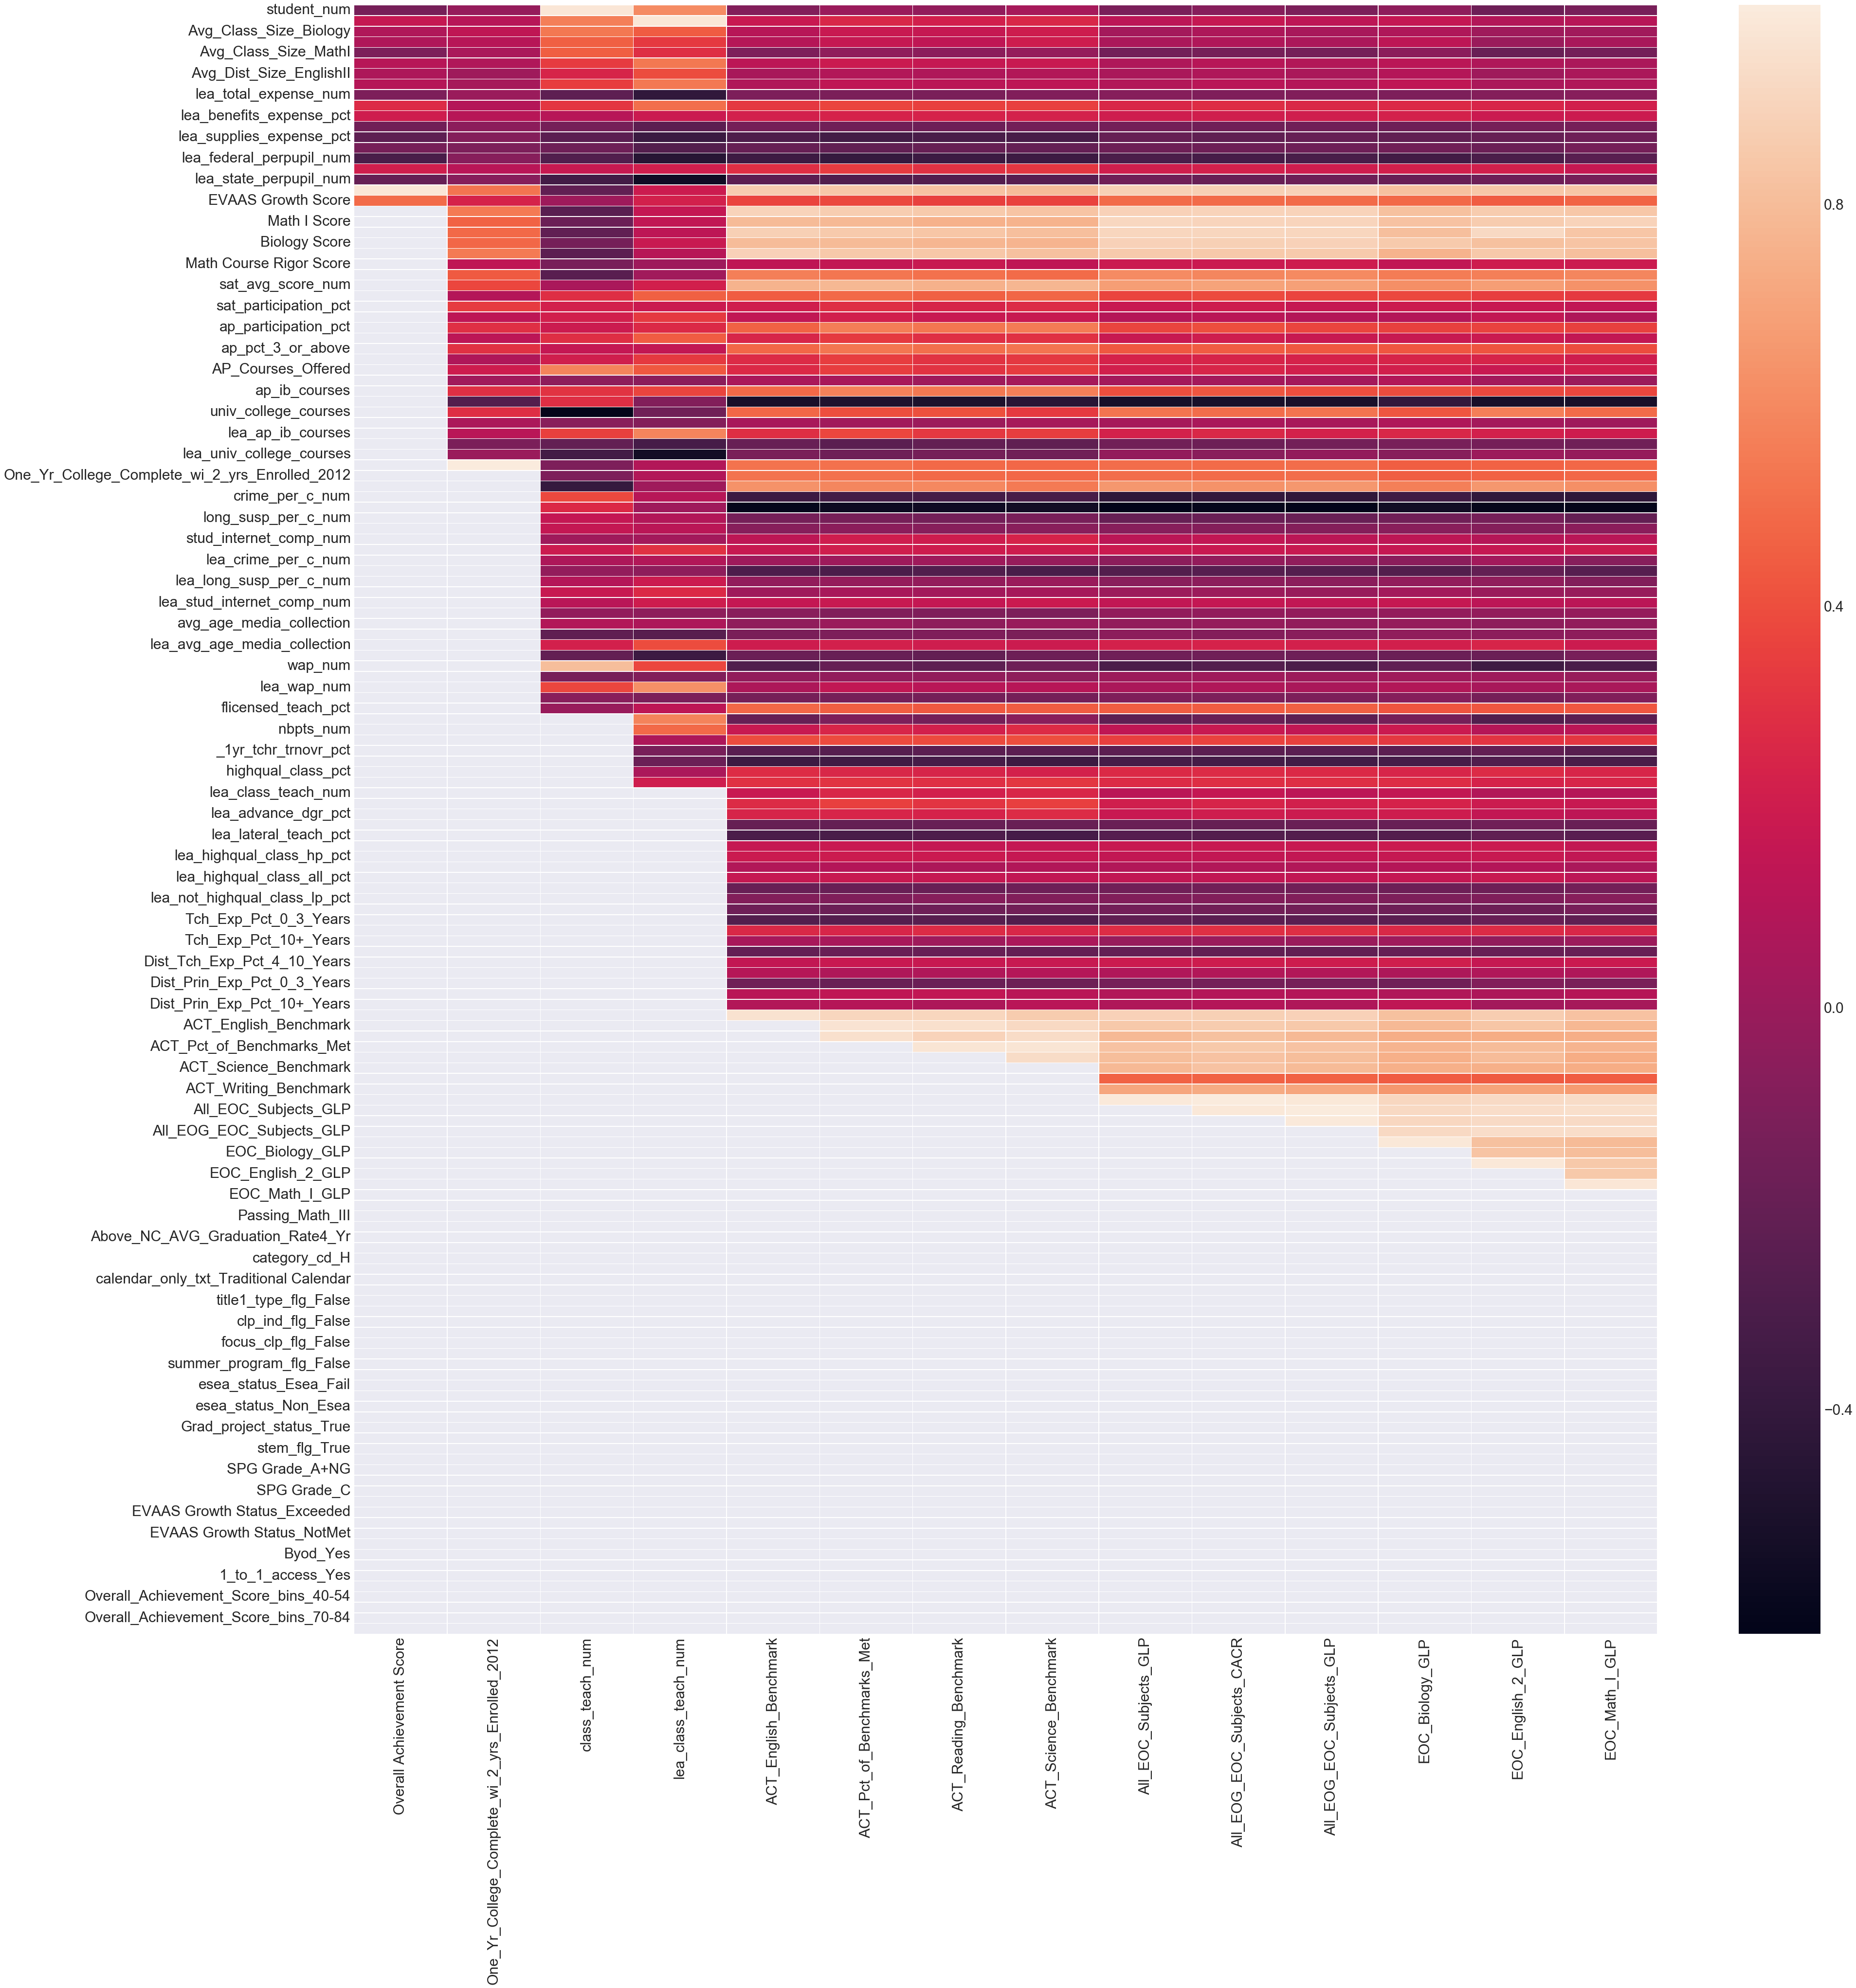

In [85]:
%%time
import seaborn as sns
%matplotlib inline
temp = modelingdata.select_dtypes(include=['int','float']) # select int to run corr on
print(temp.shape)

# calculate the correlation matrix
corr_matrix  = temp.corr()#.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

fig, ax = plt.subplots(figsize=(60,60))
sns.set(font_scale=3)
sns.heatmap(upper[to_drop], 
            #xticklabels=upper[to_drop].columns.values,
            #yticklabels=upper[to_drop].columns.values,
            linewidths=.5, ax=ax)


In [22]:
# Columns with greater than 0.95 correlations to drop
to_drop

['Overall Achievement Score',
 'One_Yr_College_Complete_wi_2_yrs_Enrolled_2012',
 'class_teach_num',
 'lea_class_teach_num',
 'ACT_English_Benchmark',
 'ACT_Pct_of_Benchmarks_Met',
 'ACT_Reading_Benchmark',
 'ACT_Science_Benchmark',
 'All_EOC_Subjects_GLP',
 'All_EOG_EOC_Subjects_CACR',
 'All_EOG_EOC_Subjects_GLP',
 'EOC_Biology_GLP',
 'EOC_English_2_GLP',
 'EOC_Math_I_GLP']

In [23]:
#Restore fontscale back to normal after heatmap
sns.set(font_scale=1)
# Drop the highly correlated features from our training data 
print('Before Drop')
print(modelingdata.shape)
print('After Drop')
modelingdata = modelingdata.drop(to_drop, axis=1)
modelingdata.shape

Before Drop
(440, 154)
After Drop


(440, 140)

> using correlation, we eliminate 14 features. Our final dataset ready for modeling has 440 records and 140 features which includes the one -hot encoded features from categorical features.

In [24]:
# create X (Exploratory) and y (response) variable

In [25]:
%%time
#Create data = x
Cls_X = modelingdata.copy()
#create target = Y
Cls_y = Cls_X.Above_NC_AVG_Graduation_Rate4_Yr
print('X shape before ')
print(Cls_X.shape)
#drop the response column from the x dataset
Cls_X.pop('Graduation_Rate4_Yr') #drop 'Graduation_Rate4_Yr'
Cls_X.pop('Above_NC_AVG_Graduation_Rate4_Yr') # drop High_Graduation_Rate4_Yr'
print('X shape after ')
print(Cls_X.shape)
print('Y shape after ')
print(Cls_y.shape)

X shape before 
(440, 140)
X shape after 
(440, 138)
Y shape after 
(440,)
Wall time: 3.01 ms


 ### Part 2 Modeling and Evaluation 


<div class="alert alert-info"><h3>
Evaluation Metrics
</h3></div>

The goal of our classification task is to build a model which predicts whether a given high schools' 4-year graduation rate is `Above (encoded as 1) ` or `Below (encoded as 0) ` the state average. The criterion for choosing our model evaluation metric was that the metric must be robust to class imbalance. We first explore metrics such as accuracy, precision, recall and F-1 ratio which can be derived from the `Confusion Matrix` and then go on to explain why we chose *AUC as our metric of choice*.   

It helps to define what each element of the confusion matrix represents before we decide on the metric.
- **True Positive**: When the school's 4-year graduation rate is **Above** state average, our classifier *correctly* predicts **Above** 
- **False Negative**: When the school's 4-year graduation rate is **Above** state average, our classifier *incorrectly* predicts **Below** 
- **False Positive**: When the school's 4-year graduation rate is **Below** state average, our classifier *incorrectly* predicts **Above** 
- **True Negative**: When the school’s 4-year graduation rate is **Below** state average, our classifier *correctly* predicts **Below**


We first explain why we are not using `Accuracy` for evaluating our classification model performance. Accuracy is the most straightforward performance measure. It is the ratio of correctly predicted observation to the total observations, in confusion matrix terms: (TP + TN)/ (TP + FP + FN + TN). In our case, we have an imbalance in the class distribution, with 73% of our dataset containing `Above` state average high schools and 27% `Below`. Due to this imbalance, the `Null Accuracy` - which is the accuracy of a classifier which always predicts the majority class, is 73%. In other words, if our classifier always predicted that a given high-school is `Above` state average, then it's accuracy would be 73%. This provides us a baseline against which we can compare other models, but it is not useful in reporting our findings. Secondly, if we use accuracy as our metric, then we would not know what *type* of errors our classifier is making, i.e. FP's or FN's. Therefore, for us to correctly report our model findings we will not use accuracy as our metric. In the code below, we show the class distribution and calculation of Null Accuracy.

In [26]:
# Explore distribuion of our class

print("our class distibution")
print(Cls_y.value_counts())

# calculate the percentage of ones
print('Percentage of ones: ', round(Cls_y.mean(),4))

# calculate the percentage of zeros
print('Percentage of Zeros: ',round(1 - Cls_y.mean(),4))

# calculate null accuracy 
print('')
print('##############################')
print('NULL Accuracy: ', max(round(Cls_y.mean(),4), round(1 - Cls_y.mean(),4)))
print('##############################')


our class distibution
1.0    321
0.0    119
Name: Above_NC_AVG_Graduation_Rate4_Yr, dtype: int64
Percentage of ones:  0.7295
Percentage of Zeros:  0.2705

##############################
NULL Accuracy:  0.7295
##############################


 For the code above we calculate a null accuracy of 73% on our whole dataset. That means that a dumb model that always predicts majority predictor in our case 1 would be right 73% of the time. When evaluating our model performance, we will be looking to ensure the they shows classification accuracy better than that of a dumb model. 

Precision, Recall(sensitivity/TPR), F1-score and specificity(FNR) are some metrics that can be calculated from the confusion matrix. 
- **Precision**: is how precise the classifier is in predicting the positive class. In other words, when the classifier predicted `Above`, how often was it right? This can be calculated from confusion matrix as TP/ (TP + FP). Low false positives lead to high precision. 
- **Recall**: is the ratio of correctly predicted positive observations to the all observations in actual class. In other words, when the actual value was `Above`, how often did the classifier predict correctly. This is calculated from confusion matrix as TP/ (TP + FN). This is also known as True Positive Rate (TPR) or Sensitivity. That is, how sensitive the classifier is to detecting positive instances.
- **F1-score**: is the harmonic mean of precision and recall. 2.(precision. recall)/ (precision + recall). This takes both FP and FN into account. Intuitively this is a bit difficult to understand and report to a wider audience.
- **Specificity**: answers the question: when the actual value is negative, how often is the prediction correct? That is, TN/ (TN + FP). This is also known as the False Negative Rate (FNR). The False Positive Rate (FPR) can be calculated as 1 - specificity.


Each of these metrics has a specific goal and the choice of picking one over the other depends on the specific needs of the problem. In our context, since our goal is to pick a metric which is robust to imbalance in class distribution, we want a metric which takes into account the TPR and FPR of the classifier. 

 Given our understanding of the above metrics, we can now explore how to adjust the performance of our classifier by adjusting the classification threshold. Most classification models in Scikit-learn output the prediction probabilities of class membership. We can make use of these prediction probabilities to adjust the performance of a classifier by adjusting the classification threshold. We can adjust both the *sensitivity* and *specificity* of a classifier simply by adjusting the classification threshold. For example, if we decrease the threshold of predicting the positive class `Above`, to say, 0.3 we can increase the sensitivity (recall) of the classifier. This increases sensitivity because the classifier is now more sensitive to positive instances. 

A receiver operating characteristic (ROC) curve allows us to see how sensitivity and specificity are affected by various thresholds. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. ROC will help us evaluate the tradeoff between sensitivity and specificity in our models. Area under the curve (AUC) is a single-number-summary of the performance of a classifier. AUC is the percentage of the ROC plot that is underneath the curve. It turns out that AUC can also be interpreted as follows, if we randomly choose 1 positive observation and 1 negative observation from our testing set, AUC represents the likelihood that our classifier would assign a higher predicted probability to the positive observation. It makes sense that this is useful goal, because ultimately, we want the classifier to rank positive observations higher than negative observations in terms of predicted probability. AUC is also robust to high class imbalance and therefore we will be using **AUC as our metric of choice. **


Thus, we will be using **AUC** as our model evaluation metric for the classification models that we build in the subsequent sections.

References: 
   * http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc
   * http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
   * http://www.ritchieng.com/machine-learning-evaluate-classification-model  

The strategy we use to divide our dataset is: 
- Use train_test_split to hold out 30% of the data for testing. This will be the data the model has not seen during it's training. 
- Use Stratified 10-fold cross validation on 70% of the training data along with GridSearchCV's parameter grid to find the best parameters. 
- Use the best parameters and the training data to retrain the model. 
- Use the retrained model and the test set to evaluate the performance of the model.


<img src="http://dthomas.mathematical.guru/Img/dataSplitting.png" width="600" height="600" />

>> **Reference:** `Introduction to Machine Learning with Python: A Guide for Data Scientists by Andreas Müller and Sarah`

<div class="alert alert-info"><h3>
Using train_test_split to hold out 30% of data for testing.
</h3></div>

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. In scikit-learn a random split into training and test sets can be quickly computed with the `train_test_split` helper function.

In [27]:
# select a seed to use for repeatability
seed = 100

In [28]:
#Split data to  into train and holding set.
X_train,X_test,y_train,y_test = train_test_split(Cls_X, Cls_y, test_size = 0.3, random_state = seed)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(308, 138)
(308,)
(132, 138)
(132,)


We will use Stratified 10-fold CV on the training set to train our classifiers.

<div class="alert alert-info"><h3>
Using Stratified 10-fold CV
</h3></div>


In stratified cross-validation, we split the data such that the proportions between classes are the same in each fold as they are in the whole dataset. It is like k-fold in that the training set is split into k smaller sets. The following procedure is followed for each of the k “folds”:
- A model is trained using `k-1` of the folds as training data;
- The resulting model is validated on the remaining part of the data, i.e., it is used as a test set to compute a performance measure such as `roc_auc`

The performance measure reported by stratified k-fold cross-validation is then the average of the values computed in the loop.


#### Classification 

In [29]:
Classification_cv = StratifiedKFold(n_splits = 10, random_state = seed)
Classification_cv

StratifiedKFold(n_splits=10, random_state=100, shuffle=False)

> With our final data set, we utilize StratifiedKFold class to create `Classification_cv` object that will be used to perform 10-fold stratified sampling of our data for Cross validation. StratifiedKFold is appropriate for our data since our dataset has class imbalance. Furthermore, creating this classification object, `Classification_cv` will allow us to compare the performance of different classification models, and model parameters on the same train/test set pairs for cross validation.

<div class="alert alert-info"><h3>
Classification Models
</h3></div>

#### KNN model with 10 fold cross validation 

>#### Data Scaling

> Standardization can be more practical for many machine learning algorithms. Using standardization, we 
center the feature columns at mean 0 with standard deviation 1, essentially creating z-scores that describe 
the shape of a standard normal distribution. This makes it easier to learn the weights and it the scaling via
standardization maintains useful information about outliers and makes the algorithm less sensitive to them in 
general allowing our KNN model to fit and perform better.

> **Reference:** `Raschka, Sebastian, and Knut Lorenzen. Machine Learning mit Python das Praxis-Handbuch für Data Science, Predictive Analytics und Deep Learning. Mitp, 2017.`

In [30]:
from sklearn.preprocessing import StandardScaler 

stdsc = StandardScaler() 
X_train_Knn = stdsc.fit_transform(X_train) 
X_train_Knn

array([[-0.57024288, -1.23253481,  0.31469049, ..., -0.74009371,
        -0.51214752, -0.33453454],
       [ 1.19951847,  1.72348323,  0.52960107, ..., -0.74009371,
        -0.51214752, -0.33453454],
       [-0.48620394,  0.02336154, -1.18968356, ..., -0.74009371,
        -0.51214752, -0.33453454],
       ..., 
       [-0.9673681 , -0.23714098,  0.52960107, ..., -0.74009371,
         1.95256242, -0.33453454],
       [ 0.15479901,  0.21805289, -0.33004124, ..., -0.74009371,
        -0.51214752, -0.33453454],
       [ 0.5716981 , -0.23439885, -0.11513067, ..., -0.74009371,
        -0.51214752, -0.33453454]])

>**Parameter description**
>* **`n_neighbors: `** Number of neighbors to use by default for kneighbors queries.
>* **`weights: `**weight function used in prediction. Possible values: 
‘uniform’ : uniform weights. All points in each neighborhood are weighted equally. 
‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
>* **`metric: `**the distance metric to use for the tree. The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric


>The KNN grid search consisted of varying n_neighbors from 2 to 50, using our weights (uniform and distance). And a default of auto for algorithm, and the default leaf size of 30  
We analyzed different metrics like minkowski, euclidean, manhattan, chebyshev. Since we scaled our data by standardization we opted not to use a penalty since our model may have overfit the training data, and we had to control these phenomena. We want to be able to apply our model to different sets and prefer it to be more robust then accurate in terms of practicality.


>** Reference:** http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 

In [31]:
%%time
from sklearn.model_selection import GridSearchCV 
param_grid = {'n_neighbors': np.arange(2, 50),
             'weights':['uniform', 'distance'],
             'metric':['minkowski','euclidean', 'manhattan', 'chebyshev']
             }
knn_test = KNeighborsClassifier() 
knn_test_cv = GridSearchCV(knn_test, param_grid, cv=Classification_cv, scoring = 'roc_auc') 
knn_test_cv.fit(X_train_Knn,y_train) 
print(knn_test_cv.best_params_) 
print(knn_test_cv.best_score_)

{'metric': 'manhattan', 'n_neighbors': 44, 'weights': 'distance'}
0.856337941812
Wall time: 2min 10s


>Our best score was about 0.85 auc with the KNN model. Our best model parameters consisted of the 'manhattan' metric, 44 n_neighbors, with the weight of distance, all other variables are defaulted as stated earlier. Note that the manhattan metric also known as the taxicab metric tracks distance best on a grid or pathway, where the shortest distance between two paths could have multiple different pathways (similar to a taxicab driving from pt A to B) and not a unique distance like the euclidean metric.

#### Random Forest model with 10 fold cross validation

>In the cell below, we utilized GridSearchCV to iterate through different subsets of parameters to extract the combination that produces the best score. Of the parameters within the RandomForestClassifier, we chose to run permutations on 'criterion', 'n_estimators' and  'max_depth'.

>**Paramater Description**
>* **`Criterion: `**
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

>* **`max_depth: `**
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

>* **`n_estimators: `** The number of trees in the forest.

>** Reference:** http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

In [32]:
%%time 
from sklearn.model_selection import GridSearchCV 
param_grid = {'n_estimators': [10, 50, 100],'criterion': ['gini', 'entropy'], 'max_depth': np.arange(1, 10)} 
rf_clf = RandomForestClassifier(n_jobs=2, random_state=seed) 
rf_clf_cv = GridSearchCV(rf_clf, param_grid, cv=Classification_cv, scoring ='roc_auc' ) 
rf_clf_cv.fit(X_train, y_train) 
print(rf_clf_cv.best_params_) 
print(rf_clf_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}
0.894553952854
Wall time: 3min 32s


#### Logistic Regression model with 10 fold cross validation



> For our logistic regression classifier, we have chosen to manipulate cost which is the most appropriate parameter to tune for our data. Cost defined as 1/lambda, with lambda being the actual regularization term is the amount of constraint violation. Regularization intuitively can be thought as a penalty against complexity. If a model suffers from (high) variance (i.e., it overfits the training data) regularization is used to increase the bias to improve the model generalization performance especially on unseen data. Caution always must be taken to ensure too much bias is not added which could otherwise result in underfitting where a model shows a "bad" performance for both the training and test dataset.  

>We analyzed accuracy of our Classifier by manipulating cost for 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, and 1000. For our dataset, smaller the cost value {0.01}, the stronger the regularization and the better our model performed with an accuracy of 82.51% on a 10K cross validation.  We also note our logistic regression classifier performance degrades with increasing cost.

> We also manipulated logistic regression parameter `Class_weight` checking the impact of switching between ‘balanced’ class weight and `none` class_weight. `None` class weight gives us best performance as equal weight gets assigned to each class. One interesting observation we note is the benefit of a `balanced` class weight kicks in when a higher cost is use. For instance, a cost of 1000 with a `balanced` class weight yields an accuracy of 78.9% 10 fold average accuracy compared to 77.92% accuracy for a cost of 1000 and `None` class weight.

>**Paramater Description**
>* **`Cost (C): `**
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

>* **`class_weight: `**
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

>** Reference:** 
>* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
>* https://www.kdnuggets.com/2016/06/regularization-logistic-regression.html


In [33]:
# titles to be used for column names for our summary tables
title = ['Run1','Run2','Run3','Run4','Run5','Run6','Run7','Run8','Run9','Run10', 'AVG_Acc', 'Cost']
title3 = ['Run1','Run2','Run3','Run4','Run5','Run6','Run7','Run8','Run9','Run10', 'AVG_Acc', 'Class_Weight']
title4 = ['Run1','Run2','Run3','Run4','Run5','Run6','Run7','Run8','Run9','Run10', 'AVG_Acc', 'Cost', 'Penalty', 'Class_weight']
title2 = [1,2,3,4,5,6,7,8,9,10, 'AVG_Acc', 'Cost']
#Logistic Regression Paramaters to manipulate to increase generalization
penalty = ['l2']
class_weight = [None, 'balanced']
cost = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]
i = 0
LR_list = []

print('#############################################')
print('Logistic Regression Model Accuracy vs Cost   ')
print('#############################################')

#For loop to evaluate accuracy for the different costs
for i in cost:
    lr_clf = LogisticRegression(C=i,class_weight=None, random_state=seed)

    acc = cross_val_score(lr_clf,  X_train, y_train, cv=Classification_cv.split(X_train, y_train))
    acc = np.append(acc,acc.mean())
    acc = np.round(np.append(acc,i), 4)
    #print(acc)
    #print(acc.mean())
    #LR_list.append(title)
    LR_list.append(list(acc))

LR_list = pd.DataFrame(LR_list)
LR_list.columns = title
display(LR_list.sort_values('AVG_Acc', ascending=False))
LR_list.columns = title2
LR_list_T =pd.melt(LR_list, id_vars=['Cost'], value_vars=[1,2,3,4,5,6,7,8,9,10])
LR_list_T.columns = ['Cost', 'Run', 'Accuracy']

#For loop to evaluate accuracy for the different penalty
print('#############################################')
print('Logistic Regression Model Accuracy vs Class Weight  ')
print('#############################################')
#LR_list_T
LR_list2 = []
for i in class_weight:
    lr_clf = LogisticRegression(penalty=penalty[0], C = 0.05, class_weight=i, random_state=seed)

    acc = cross_val_score(lr_clf,  X_train, y_train, cv=Classification_cv.split(X_train, y_train))
    acc = np.round(np.append(acc, acc.mean()),4)
    acc = np.append(acc,i)
    #print(acc)
    #print(acc.mean())
    #LR_list.append(title)
    LR_list2.append(list(acc))

LR_list2 = pd.DataFrame(LR_list2)
LR_list2.columns = title3

display(LR_list2)
#For loop to evaluate accuracy for the different penalty
print('##################################################################')
print('Logistic Regression Model Accuracy vs weight and Cost Combination')
print('##################################################################')
LR_list3 = []
for i in cost:
    for j in penalty:
        for k in class_weight:
            lr_clf = LogisticRegression(penalty=j, C = i, class_weight=k, random_state=seed)

            acc = cross_val_score(lr_clf,  X_train, y_train, cv=Classification_cv.split(X_train, y_train))
            acc = np.round(np.append(acc, acc.mean()),4)
            acc = np.append(acc,i)
            acc = np.append(acc,j)
            acc = np.append(acc,k)
            #print(acc)
            #print(acc.mean())
            #LR_list.append(title)
            LR_list3.append(list(acc))

LR_list3 = pd.DataFrame(LR_list3)
LR_list3.columns = title4
display(LR_list3.sort_values('AVG_Acc', ascending=False))




#############################################
Logistic Regression Model Accuracy vs Cost   
#############################################


,Run1,Run2,Run3,Run4,Run5,Run6,Run7,Run8,Run9,Run10,AVG_Acc,Cost
0,0.7812,0.9032,0.7742,0.9032,0.7742,0.7742,0.7742,0.8333,0.8333,0.9000,0.8251,0.01
1,0.7812,0.9032,0.8065,0.9032,0.7742,0.7097,0.8387,0.8000,0.8000,0.8667,0.8183,0.05
2,0.7812,0.9032,0.8065,0.8710,0.8065,0.7097,0.8387,0.8000,0.7667,0.8667,0.8150,0.10
3,0.7500,0.9032,0.7742,0.8710,0.8065,0.6452,0.8387,0.8000,0.7000,0.8667,0.7955,0.50
7,0.7500,0.9032,0.7742,0.8387,0.8065,0.6452,0.8710,0.8000,0.7000,0.8667,0.7955,100.00
5,0.7500,0.9355,0.7419,0.8710,0.7742,0.6452,0.8387,0.8000,0.7000,0.8667,0.7923,5.00
6,0.7500,0.9355,0.7419,0.8387,0.8065,0.6452,0.8710,0.8000,0.7000,0.8333,0.7922,10.00
4,0.7500,0.9032,0.7419,0.8387,0.8065,0.6452,0.8710,0.8000,0.7000,0.8333,0.7890,1.00
8,0.7500,0.9355,0.7419,0.8387,0.7742,0.6452,0.8710,0.8000,0.7000,0.8333,0.7890,1000.00


#############################################
Logistic Regression Model Accuracy vs Class Weight  
#############################################


,Run1,Run2,Run3,Run4,Run5,Run6,Run7,Run8,Run9,Run10,AVG_Acc,Class_Weight
0,0.7812,0.9032,0.8065,0.9032,0.7742,0.7097,0.8387,0.8,0.8,0.8667,0.8183,None
1,0.7812,0.871,0.7097,0.9032,0.7742,0.7419,0.8065,0.7667,0.7667,0.8333,0.7954,balanced


##################################################################
Logistic Regression Model Accuracy vs weight and Cost Combination
##################################################################


,Run1,Run2,Run3,Run4,Run5,Run6,Run7,Run8,Run9,Run10,AVG_Acc,Cost,Penalty,Class_weight
0,0.7812,0.9032,0.7742,0.9032,0.7742,0.7742,0.7742,0.8333,0.8333,0.9,0.8251,0.01,l2,None
2,0.7812,0.9032,0.8065,0.9032,0.7742,0.7097,0.8387,0.8,0.8,0.8667,0.8183,0.05,l2,None
4,0.7812,0.9032,0.8065,0.871,0.8065,0.7097,0.8387,0.8,0.7667,0.8667,0.815,0.1,l2,None
1,0.7812,0.9032,0.7097,0.9032,0.7742,0.7742,0.7097,0.8333,0.8,0.8333,0.8022,0.01,l2,balanced
6,0.75,0.9032,0.7742,0.871,0.8065,0.6452,0.8387,0.8,0.7,0.8667,0.7955,0.5,l2,None
14,0.75,0.9032,0.7742,0.8387,0.8065,0.6452,0.871,0.8,0.7,0.8667,0.7955,100.0,l2,None
3,0.7812,0.871,0.7097,0.9032,0.7742,0.7419,0.8065,0.7667,0.7667,0.8333,0.7954,0.05,l2,balanced
5,0.75,0.871,0.6774,0.9032,0.7742,0.7742,0.8065,0.7667,0.7667,0.8333,0.7923,0.1,l2,balanced
10,0.75,0.9355,0.7419,0.871,0.7742,0.6452,0.8387,0.8,0.7,0.8667,0.7923,5.0,l2,None
12,0.75,0.9355,0.7419,0.8387,0.8065,0.6452,0.871,0.8,0.7,0.8333,0.7922,10.0,l2,None


## Analyzing the results of cross-validation using AUC

It is often helpful to visualize the results of cross-validation, to understand how the model generalization depends on the parameters that we found to be most optimal. As we found in the above section, the best parameters are:

- KNN: **{'metric': 'manhattan', 'n_neighbors': 44, 'weights': 'distance'}** 
- RandomForsest: **{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}** 
- LogisticRegression: **{'penalty'='l2', 'C' = 0.01, 'class_weight'=None}**  

To help visualize the AUC score for each fold we created a helper function called `ROC_plotter`. Thus function takes the model with optimal parameters and fits it to the same training data that was used in GridSearchCV and plots the ROC curve for each fold. This will help us visually assess how each fold performs. `ROC_plotter` takes the following arguments:
- **clf** : the model with best parameters
- **classification_type** : KNN or RandomForest or LogisticRegression
- **cv** :  The same Classification_cv object that we used in the above section
- **X** :  X_train, the training data we used in the above section
- **y** :  y_train, the training labesl we used in the above section

In [34]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# clf -> the model with best parameters
# classification_type -> KNN or RandomForest or LogisticRegression
# cv -> The same Classification_cv object that we used in the above section
# X -> X_train, the training data we used in the above section
# y -> y_train, the training labesl we used in the above section
def ROC_plotter(clf,classfication_type,cv = Classification_cv, X = X_train.values, y = y_train.values):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i= 0

    f, ax = plt.subplots(figsize=(15, 8))
    for train, test in cv.split(X, y):       
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.5,
                 label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=3, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
     #                label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.005, 1.05])
    plt.ylim([-0.005, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + classfication_type)
    plt.legend(loc="lower right")
    plt.show()

Automatically created module for IPython interactive environment


#### Analyzing KNN cross-validation results

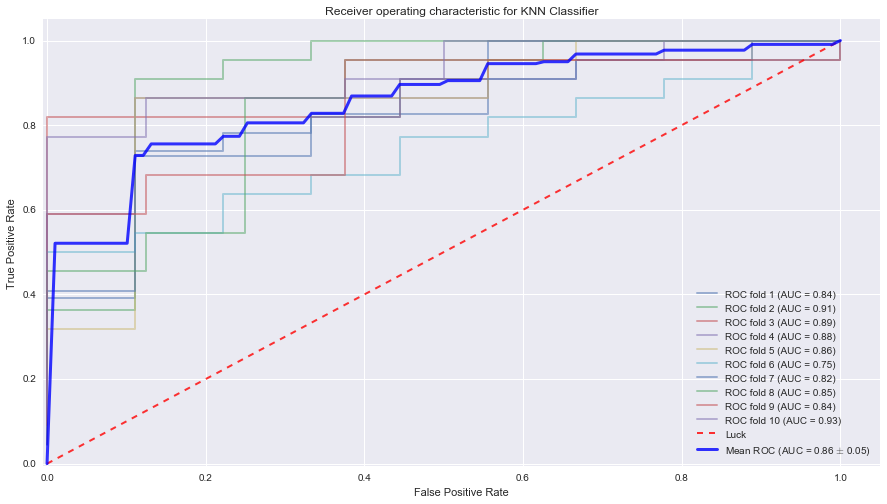

In [35]:
# Instantiate the model with best parameters found using GridSearchCV.
knn_clf = KNeighborsClassifier(metric='manhattan', n_neighbors=44, weights='distance')

# Invoke ROC_plotter using the above model and the scaled Training data that was used for GridSearchCV.
ROC_plotter(knn_clf, 'KNN Classifier', X=X_train_Knn)


Each line in the above plot corresponds to one run of cross-validation. Looking at this plot, one might get a sense of how the AUC value varies from fold-to-fold and get an idea of the best and worst cases of how the model might generalize to unseen data. The mean AUC value for the 10-fold Stratified CV is found to be 0.86 with a standard deviation of 0.05. However, this mean AUC value should not be reported as the true measure of the model performance.

#### Analyzing the KNN test results

To get a true measure of how the model performs on unseen data, we make use of the 30% of test data that we have set aside.

Fitting the GridSearchCV object not only searches for the best parameters, but also automatically fits a new model on the whole training dataset with the parameters that yielded the best cross-validation performance. Thus, we can make use of the GridSearchCV object: `knn_clf_cv_s` from the previous section to make prediction on the test set.

Note that before we trained our KNN model, we Standardized the X_train feature matrix. We apply the same Standarization to the X_test matrix for calculating the AUC score.

In [36]:
# Standardize the Test set.
stdsc = StandardScaler() 
X_test_Knn = stdsc.fit_transform(X_test) 

# Calculate test auc score
roc_auc_score(y_test, knn_test_cv.predict(X_test_Knn))

0.71999999999999997

There is a significant difference in the values obtained during model evaluation using Cross-Validation (*84%*) and the value obtained on unseen test data (*72%*). This indicates that the model that we trained is **overfitting** and not able to generalize well to unseen data.

### Analyzing RandomForest cross validation results

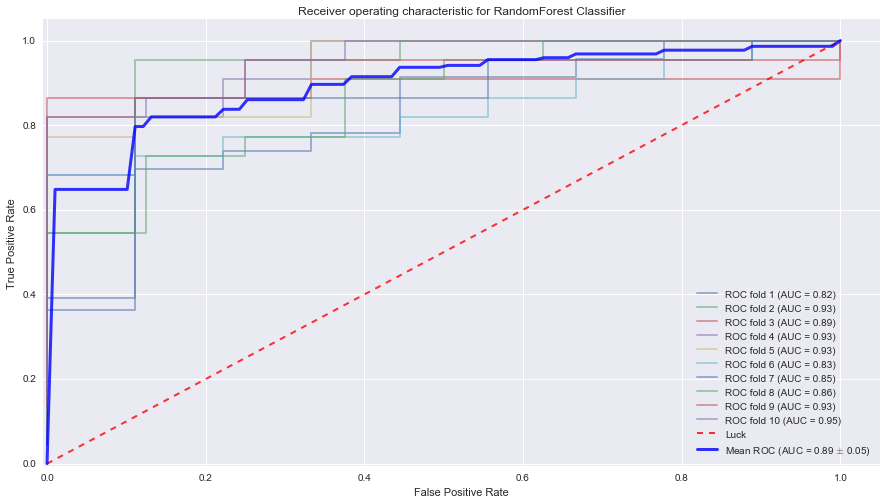

In [37]:
# {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}
rf_clf = RandomForestClassifier(n_jobs=2, criterion='entropy', max_depth=9, n_estimators=100, random_state=seed)

# Invoke ROC_plotter using the above model and the training data that was used for GridSearchCV.
ROC_plotter(rf_clf, 'RandomForest Classifier')

Each line in the above plot corresponds to one run of cross-validation. Looking at this plot, one might get a sense of how the AUC value varies from fold-to-fold and get an idea of the best and worst cases of how the model might generalize to unseen data. The mean AUC value for the 10-fold Stratified CV is found to be 0.89 with a standard deviation of 0.05. However, this mean AUC value should not be reported as the true measure of the model performance.

#### Analyzing the RandomForestClassifier test results

Using the GridSearchCV object: rf_clf_cv we can calculate the AUC score for test data.

In [38]:
# Calculate test auc score
roc_auc_score(y_test, rf_clf_cv.predict(X_test))

0.82499999999999996

With an AUC score of 0.825 obtained from predicting on unseen test data, suggests that our RandomForest classifier is doing quite well.

### Analyzing LogisticRegression cross validation results

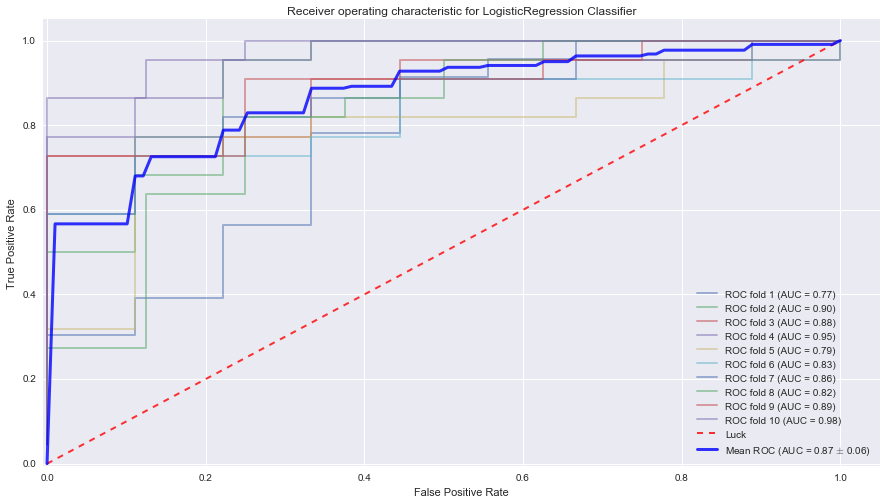

In [39]:
lr_clf = LogisticRegression(penalty='l2', C = 0.01, class_weight=None, random_state=seed)

# Invoke ROC_plotter using the above model and the training data used in the previous section
ROC_plotter(lr_clf, 'LogisticRegression Classifier')

Each line in the above plot corresponds to one run of cross-validation. Looking at this plot, one might get a sense of how the AUC value varies from fold-to-fold and get an idea of the best and worst cases of how the model might generalize to unseen data. The mean AUC value for the 10-fold Stratified CV is found to be 0.87 with a standard deviation of 0.06. However, this mean AUC value should not be reported as the true measure of the model performance.

#### Analyzing the LogisticRegression Classifier test results

For Logistic Regression, we did not use GridSearchCV but instead we used a for-loop to find the best parameters. For this reason, we re-train the Logistic Regression model using the training set with the best parameters.

In [40]:
# fit this to training
lr_clf.fit(X_train, y_train)

# predict and calculate auc on test data
roc_auc_score(y_test, lr_clf.predict(X_test))

0.76249999999999996

There is a significant difference in the values obtained during model evaluation using Cross-Validation (*87%*) and the value obtained on unseen test data (*76.24%*). This indicates that the model that we trained is **overfitting** and not able to generalize well to unseen data.

>**Reference** 
>* http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
>* https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
>* http://pages.cs.wisc.edu/~dpage/cs760/evaluating.pdf
>* http://scikit-plot.readthedocs.io/en/stable/apidocs.html

<div class="alert alert-info"><h3>
Discussing the Advantages, Disadvantages and Models Statistical Comparison 
</h3></div>

###  Advantages and Disadvantages

#### `Computational complexity and Running Time: `

**KNN** and <span style="color:red">**Random Forest** </span> have the downside of computational complexity. For both, Computational complexity grows linearly with the number of samples in the training dataset in the worst-case scenario.  In the case of a KNN unless the dataset has very few dimensions (features) and the algorithm has been implemented using efficient data structures such as KD-trees it could take longer time to run. Random forest would be the worst at runtime and computational complexity as the number of trees increases.

#### ` Overfitting and Overconfidence` 

It is important to mention that **KNN** is very susceptible to overfitting due to the curse of dimensionality. The curse of dimensionality describes the phenomenon where the feature space becomes increasingly sparse for an increasing number of dimensions of a fixed-size training dataset. For this reason we had to scale our dataset to bring all features to the same scale for KNN classfication. This greatly improved our model accuracy 

**Logistic regression**  on the other hand tends to be vulnerable to overconfidence in cases involving imbalanced classes. In such cases, Logistic regression model tends to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.  This was a particular important aspect to consider for our model where our predicted variable `Above_NC_AVG_Graduation_Rate4_Yr` is imbalanced with False: 119 and True: 321 observations. 

Considering overfitting, <span style="color:green">**Random Forest**</span> is the clear winner as it mitigates noise of decision trees by aggregating their individual predictions. Having more trees in your forest produces better results which is a clear advantage in our classfication as we are dealing with unbalanced classes.


#### ` Interpratability`

<span style="color:green">**Logistic Regression**</span> takes a simple nice probabilistic interpretation approach.  Since Predictions are mapped to be between 0 and 1 through the logistic function, predictions can be interpreted as class probabilities. This makes Logistic regression a much simpler model to interpret compared to Random Forest and K Nearest neighbor classification. 

>**Reference**
>* (J. H. Friedman, J. L. Bentley, and R. A. Finkel. An algorithm for finding best matches 
in logarithmic expected time. ACM Transactions on Mathematical Software (TOMS), 3(3):209–226, 1977.)
>* https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/

### ROC and AUC Comparison

Automatically created module for IPython interactive environment


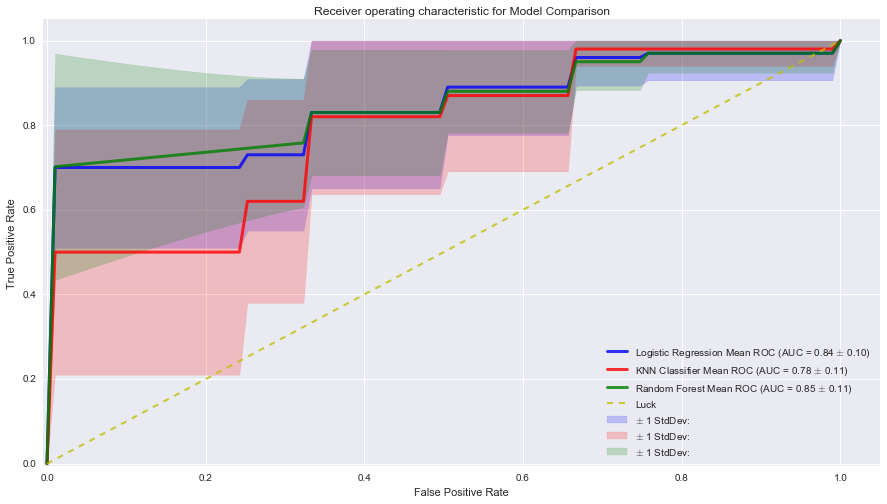

In [45]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#lr_clf = LogisticRegression(penalty='l1', C = 0.01, class_weight=None, random_state=seed)

classifiers = [lr_clf, knn_clf, rf_clf]
model = ['Logistic Regression', 'KNN Classifier', 'Random Forest']
colors = ['b','r','g']

def ROC_Compare(cv = Classification_cv, X = X_test.values, y = y_test.values):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i= 0
    p =0

    f, ax = plt.subplots(figsize=(15, 8))
    for p in range(3):
        for train, test in cv.split(X, y):       
            probas_ = classifiers[p].fit(X[train], y[train]).predict_proba(X[test])
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=2, alpha=0.5,
             #        label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

            i += 1


        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color=colors[p],
                 label=r''+model[p]+' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=3, alpha=.8)
        std_tpr = np.std(tprs, axis=0)
        #tprs_upper = np.max(std_tpr)
        #tprs_lower = np.min(std_tpr)
        tprs_upper = np.minimum(mean_tpr + (std_tpr), 1)
        tprs_lower = np.maximum(mean_tpr - (std_tpr), 0)
        i= 0
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[p], alpha=.2,
                        label=r'$\pm$ 1 StdDev:')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='y',
         label='Luck', alpha=.8)
    p +=1
    plt.xlim([-0.005, 1.05])
    plt.ylim([-0.005, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Model Comparison')
    plt.legend(loc="lower right")
    plt.show()
    
ROC_Compare()

While we believe Random Forest to be the best classifier, the amount of overlap between the three models using AUC considering 95% confidence interval shows no clear statistical distinction between them. 

<div class="alert alert-info"><h3>
Feature Importance
</h3></div>

> Like in many real world classification problems where feature importance is often unknown a priori, we choose to begin with using prediction accuracy of our model narrow down on a subset of features to use without significantly decreasing prediction accuracy of the classifiers. Below we calculate the accuracies of our Classification methods (Logistic Regression, Random Forest and KNN) based on a percetage of features selected by Chi-Squared test. Chi-square test measures dependence between our predictor and exploratory variables as such using Chi-Squared test, we weed out the features that are the most likely to be independent of class and therefore irrelevant for classification.

In [46]:
%%time
from sklearn import cross_validation
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

percentiles = range(1, 100, 5)
results = []
results1 = []
results2 = []
for i in range(1, 100, 5):
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_validation.cross_val_score(lr_clf, X_train_fs, y_train, cv=Classification_cv.split(X_train_fs, y_train))
    scores1 = cross_validation.cross_val_score(rf_clf, X_train_fs, y_train, cv=Classification_cv.split(X_train_fs, y_train))
    scores2 = cross_validation.cross_val_score(knn_clf, X_train_fs, y_train, cv=Classification_cv.split(X_train_fs, y_train))
    print(i,' LR : ',scores.mean())
    print(i,' RF :',scores1.mean())
    print(i,' KNN :',scores2.mean())
    results = np.append(results, scores.mean())
    results1 = np.append(results1, scores1.mean())
    results2 = np.append(results2, scores2.mean())


1  LR :  0.717681451613
1  RF : 0.685
1  KNN : 0.659193548387
6  LR :  0.802311827957
6  RF : 0.789603494624
6  KNN : 0.711021505376
11  LR :  0.79251344086
11  RF : 0.80875672043
11  KNN : 0.753172043011
16  LR :  0.785745967742
16  RF : 0.789180107527
16  KNN : 0.759831989247
21  LR :  0.831444892473
21  RF : 0.824475806452
21  KNN : 0.753272849462
26  LR :  0.818333333333
26  RF : 0.828125
26  KNN : 0.756505376344
31  LR :  0.818333333333
31  RF : 0.808239247312
31  KNN : 0.756505376344
36  LR :  0.815208333333
36  RF : 0.805537634409
36  KNN : 0.756505376344
41  LR :  0.825100806452
41  RF : 0.808447580645
41  KNN : 0.736827956989
46  LR :  0.815423387097
46  RF : 0.795759408602
46  KNN : 0.736827956989
51  LR :  0.812305107527
51  RF : 0.801995967742
51  KNN : 0.736827956989
56  LR :  0.815215053763
56  RF : 0.811673387097
56  KNN : 0.736827956989
61  LR :  0.815215053763
61  RF : 0.805221774194
61  KNN : 0.736827956989
66  LR :  0.818440860215
66  RF : 0.802311827957
66  KNN : 0.

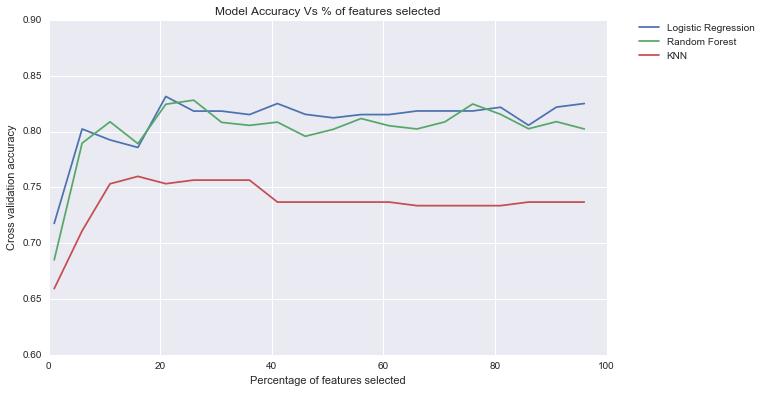

In [47]:
###### Plot percentile of features VS. cross-validation scores
import pylab as pl
pl.figure()
f, ax = plt.subplots(figsize=(10, 6))
pl.xlabel("Percentage of features selected")
pl.ylabel("Cross validation accuracy")
pl.plot(percentiles,results, label="Logistic Regression")
pl.plot(percentiles,results1, label="Random Forest")
pl.plot(percentiles,results2, label="KNN")
plt.axis([0, 100, 0.6, 0.9])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Model Accuracy Vs % of features selected')
plt.grid(True)

> The figure above Visualizes comparison of cross validation accuracy vs percentage of features selected for Logistic Regression, Random Forest and KNN classifiers on predicting whether a school 4-year high school graduation rate is above or below the NC states average graduation rate. 

> **We note the following trends: ** 

> 1. For Logistic Regression, KNN and Random Forest model; 21% of the features gives us the best performing models in terms of accuracy.  Beyond 21% of the features, we don't gain much benefit on the predictive power of our classifiers.

> 2.  Across the board, logistic regression and Random Forest are both competitive in terms of their predictions accuracy and superior to KNN classifier regardless of the number of features used.

> Below we list the top features identified by Chi-Squared test.


In [41]:
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=21)
df_X_train_fs = fs.fit_transform(X_train, y_train)

np.set_printoptions(suppress=True, precision=2, linewidth=80)
#print(fs.get_support())
#print(fs.scores_)
#print('')
Chi2_Score = pd.DataFrame()

for i in range(len(X_train.columns.values)):
    if fs.get_support()[i]:
        #print(df_X.columns.values[i],'\t', fs.scores_[i] )
        Feature ={'Feature': X_train.columns.values[i], 'chi-squared':fs.scores_[i]}
        Chi2_Score =Chi2_Score.append(Feature, ignore_index=True)
Chi2_Score.sort_values('chi-squared', ascending=False)   

,Feature,chi-squared
17,lea_wap_num,34792.725224
2,lea_local_perpupil_num,4652.046900
1,lea_federal_perpupil_num,1679.188577
0,lea_avg_student_num,1340.333029
14,short_susp_per_c_num,1151.504912
3,lea_state_perpupil_num,773.551238
26,EOC_Math_I_CACR,586.036513
20,ACT_Math_Benchmark,545.857751
22,ACT_Writing_Benchmark,504.480468
23,All_EOC_Subjects_CACR,488.783472


http://scikit-plot.readthedocs.io/en/stable/apidocs.html
### Feature importance for Random Forest

                                   feature  importance
24   Cohort Graduation Rate Standard Score  0.082365  
17   SPG Score                              0.043835  
100  SchoolWeightedScore                    0.041699  
20   English II Score                       0.031380  
45   short_susp_per_c_num                   0.030240  
97   EOC_English_2_CACR                     0.029122  
95   All_EOC_Subjects_CACR                  0.027402  
96   EOC_Biology_CACR                       0.022920  
19   Math I Score                           0.018810  
21   Biology Score                          0.017339  
91   ACT_Composite_Score_UNC_Min            0.016640  
35   ap_ib_courses                          0.016472  
92   ACT_Math_Benchmark                     0.015402  
15   lea_local_perpupil_num                 0.015263  
94   ACT_Writing_Benchmark                  0.015022  
25   sat_avg_score_num                      0.013867  
36   cte_courses                            0.013485  
43   avg_d

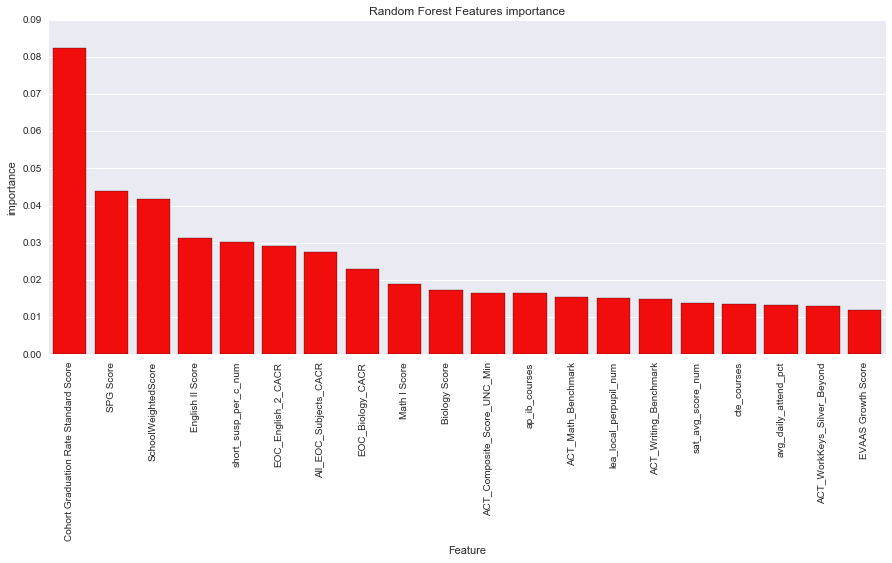

In [47]:
#https://stackoverflow.com/questions/22361781/how-does-sklearn-random-forest-index-feature-importances
rf_clf.fit(X_train, y_train)
importances = pd.DataFrame({'feature':X_train.columns, 'importance': rf_clf.feature_importances_}) 
importances = importances.sort_values('importance',ascending=False)#.set_index('feature') 
 
#only display top 20 importances[:10].plot.bar()
topDF1 = importances.head(20)
print(topDF1)

f, ax = plt.subplots(figsize=(15, 6))

g = sns.barplot('feature', y="importance", data=topDF1, color="red", saturation=.9, ci=68)
g =plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('importance')
plt.title('Random Forest Features importance')

### Feature importance for Logistic Regression

Cohort Graduation Rate Standard Score 0.267629857025
short_susp_per_c_num 0.120850235738
Overall_Achievement_Score_bins_40-54 0.100677626557
lea_books_per_student 0.0940570002973
lea_ap_participation_pct 0.074868076238
SPG Score 0.0741615842609
Overall_Achievement_Score_bins_70-84 0.0716113142823
lea_wap_num 0.0690296799512
lea_avg_student_num 0.069024241477
English II Score 0.0682914712269
lea_ap_ib_courses 0.0681972573142
lea_1yr_tchr_trnovr_pct 0.0680633437582
EOC_Math_I_CACR 0.066367421165
All_EOC_Subjects_CACR 0.0648300378814
SchoolWeightedScore 0.064196388946
avg_daily_attend_pct 0.0641015362712
Dist_Tch_Exp_Pct_0_3_Years 0.0640914469949
Biology Score 0.0635914321167
lea_sat_participation_pct 0.062873810664
avg_age_media_collection 0.0612167262849
lea_local_perpupil_num 0.0611590737664


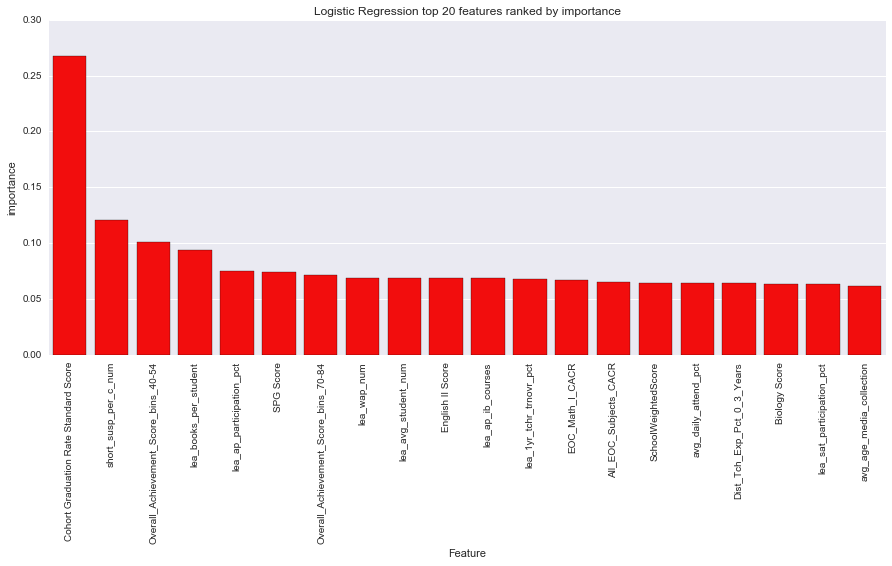

In [50]:
from sklearn.linear_model import LogisticRegression


# fit the model
#lr_clf.fit(X_train, y_train)
lr_clf.fit(X_train/ np.std(X_train, 0), y_train) #Scale the data before feature importance

# coefs
coefs = list(abs(lr_clf.coef_[0]))

# features
features = list(X_train.columns)


weights = pd.Series(coefs,index=features) 
top20 = abs(weights).sort_values(ascending = False).head(20) 


# zip them up
zipped = list(zip(features, coefs))

# create dictionary
coef_features = dict(zipped)

import operator
sorted_coef_features = sorted(coef_features.items(), key=operator.itemgetter(1), reverse=True)

# print the top 20 features with the heighest weights. 
i = 0
for feature, weight in sorted_coef_features:
    if (i <= 20):
        print(feature, weight)
        i=i+1

topDF = weights[top20.index] 
#ax = topDF.head(n=20).plot(kind='bar',figsize = (14, 8), color = 'b')
f, ax = plt.subplots(figsize=(15, 6))

topDF=pd.DataFrame(topDF)
topDF.columns = ['importance']

g = sns.barplot(topDF.index, y="importance", data=topDF, color="red", saturation=.9, ci=68)
g =plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('importance')
plt.title('Logistic Regression top 20 features ranked by importance')

>Above we show the top 20 most important features for both Logistic regression and Random Forest classifiers. 

> We see quite a bit of overlap between features that are ranked as important in both Random forest and Logistic regression models. 

> Features related to Education attainment i.e. `Cohort Graduation Rate Standard Score`, `SPG Score`, `SchoolWeightedScore``English II Score`  , `English II Score` , `EOC_English_2_CACR`,  `Math I Score`  , `Biology Score`, `EVAAS Growth Score` e.tc. dominate the list of features that our classifier is relying on when classifying whether school is classified as having a 4-year graduation rate that is above or below the NC states average graduation rates. These features strongly support the theory, school performance in this education attainment measures are a strong indicator in predicting a school’s graduation rate.

> It has interesting to see a number of the features that we created are actually being weighted as important features for our logistic regression classifier especially. These features include `Overall_Achievement_Score_bins_40-54`, `Overall_Achievement_Score_bins_70-84 and `SchoolWeightedScore` which we describe in detail in the new features section




###  Part 3. Deployment 

At present, our model would provide a school with a prediction of whether or not they would surpass a given threshold for the metric of four-year graduation rates. The school would provide the necessary data that we would feed into the model and then we could provide them with a prediction of above or below the threshold.

This model could also be useful at the state level. Once the data has been collected by the schools, the state could have predictions on which schools will meet the threshold rate set by the state. This information would provide the state legislature a preview of where their schools will be in May, giving them a head start on funding decisions and in identifying schools which are projected to not meet specified graduation rates.

While this prediction is perhaps too specific and could be seen as providing little utility, the implications for improvement are obvious. The most important value gain of this model is this; when determining the four-year graduation rates of the school, we now know key variables that the model takes into account. This model merely serves as a foundation for further tuning that could provide more accurate predictions, deeper dives into the effects of individual dependent variables, and school specific predictions with the addition of year-over-year data.

To keep the model up to date, a yearly update of the graduation rates along with all the exploratory variables from individual schools will need to be feedback to the model to compare with the models' predictions. 


###  PART 4.  Exceptional Work  

####  Varying Threshold for converting the Graduation_Rate4_Yr to a binary Feature


In [51]:
### code below is is adopted and modified from Dr Drew's code to collect evaluation statistics

In [52]:
from sklearn.model_selection import cross_validate
from sklearn import metrics
def EvaluateClassifierEstimator(model,Thresh,classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores =cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)
    
    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()
    

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"


    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))

    #print('*********************************************************')

    #print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    scoresResults['Model'] = model
    scoresResults['Predictor Threshold'] = Thresh
    scoresResults['Fold'] = scoresResults.index

    return scoresResults


In [55]:
thresh = [70, 75,78, 80, 83, 85,87, 90,93, 95, 97]

Data = pd.DataFrame()
c =0
classifiers = [knn_clf, rf_clf, lr_clf]
model = ['KNN Classifier', 'Random Forest', 'Logistic Regression']


X = Cls_X.copy()

c =0
classifiers = [knn_clf, rf_clf, lr_clf]
model = ['KNN Classifier', 'Random Forest', 'Logistic Regression']
for i in thresh:
    for c in range(len(model)):
        print('################################################################################################################')
        print('Cross Validation Fold Mean Error Scores for ' + model[c] +' with predictor Class split threshold of' +str(i) + '%')
        print('###############################################################################################################')
        y = modelingdata.Graduation_Rate4_Yr >= i # threshhold of 
        Data =  pd.concat([Data, EvaluateClassifierEstimator(model[c],i,classifiers[c], X, y, Classification_cv)])

display(Data)

################################################################################################################
Cross Validation Fold Mean Error Scores for KNN Classifier with predictor Class split threshold of70%
###############################################################################################################
The average accuracy for all cv folds is: 			 0.99111
The average precision for all cv folds is: 			 0.99111
The average recall for all cv folds is: 			 1.0
################################################################################################################
Cross Validation Fold Mean Error Scores for Random Forest with predictor Class split threshold of70%
###############################################################################################################
The average accuracy for all cv folds is: 			 0.99111
The average precision for all cv folds is: 			 0.99111
The average recall for all cv folds is: 			 1.0
#################################

,Accuracy,Precision,Recall,Model,Predictor Threshold,Fold
0,0.977778,0.977778,1.000000,KNN Classifier,70,0
1,0.977778,0.977778,1.000000,KNN Classifier,70,1
2,0.977778,0.977778,1.000000,KNN Classifier,70,2
3,0.977778,0.977778,1.000000,KNN Classifier,70,3
4,1.000000,1.000000,1.000000,KNN Classifier,70,4
5,1.000000,1.000000,1.000000,KNN Classifier,70,5
6,1.000000,1.000000,1.000000,KNN Classifier,70,6
7,1.000000,1.000000,1.000000,KNN Classifier,70,7
8,1.000000,1.000000,1.000000,KNN Classifier,70,8
9,1.000000,1.000000,1.000000,KNN Classifier,70,9


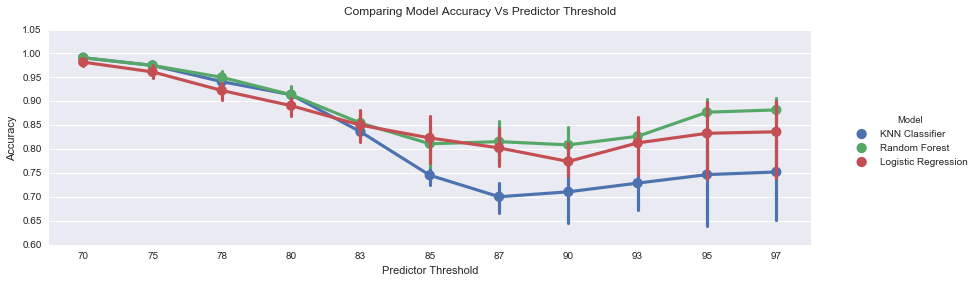

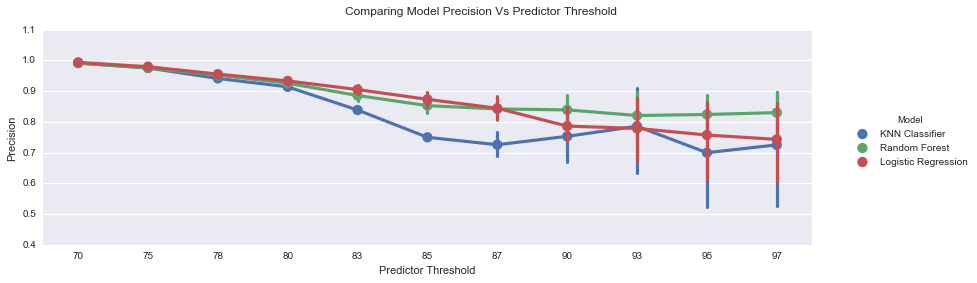

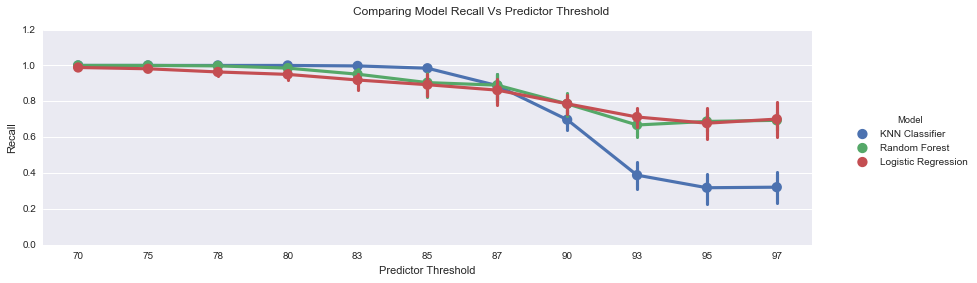

In [56]:
# Factor Plot
List = ['Accuracy','Precision', 'Recall']

for i in List:
    g = sns.factorplot(x='Predictor Threshold', 
                       y=i, 
                       data=Data,
                       Size = 20,
                       aspect  = 3,
                       legend =True,
                       margin_titles=True,
                       hue='Model',  # Color by stage
                       #col='Model',  # Separate by stage
                       kind='point') # Swarmplot
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Comparing Model '+ i + ' Vs Predictor Threshold')

The accuracy, precision and recall for Random Forest and Logistic regression classifier follow the same trend with varying threshold which we used to convert our predictor, `Graduation_Rate4_Yr`, to a binary feature. We see a significant drop in the KNN classifier as the threshold increases. 

When the classes are imbalanced, our classifiers seem to perform better.

When our classes are evenly balanced, our classifiers struggle with the correctly classifying the schools.